## Imports

In [11]:
import numpy as np
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from pandas.plotting import scatter_matrix
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import confusion_matrix, f1_score, average_precision_score, classification_report, fbeta_score, accuracy_score
from sklearn.feature_selection import RFECV

from statsmodels.stats.outliers_influence import variance_inflation_factor

import optuna
import statsmodels.api as sm
from boruta import BorutaPy

import custom_map

In [12]:
import importlib

importlib.reload(custom_map)

<module 'custom_map' from '/Users/dominikmika/PycharmProjects/Ridge-hillclimbing/custom_map.py'>

## Data and feature engineering

In [13]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [14]:
target = "stroke"

categorical_features = data.select_dtypes(['object']).columns.tolist()
numerical_features = data.select_dtypes(['float64', 'int64']).columns.drop('id')
categorical_features.append('stroke')

print(categorical_features, '\n', numerical_features)

data.head()

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke'] 
 Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke'],
      dtype='object')


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


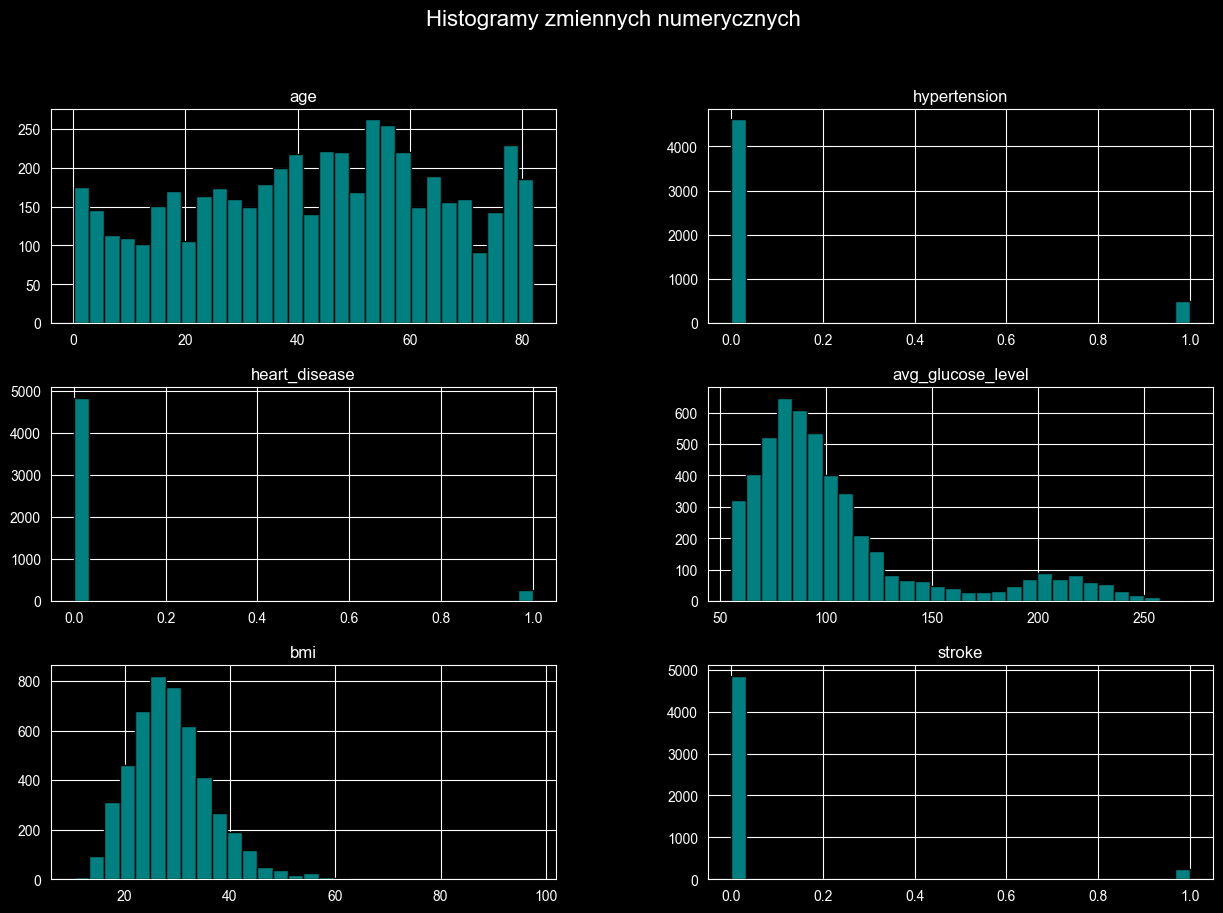

In [15]:
data[numerical_features].hist(bins=30, figsize=(15, 10), color="teal", edgecolor='black')
plt.suptitle("Histogramy zmiennych numerycznych", fontsize=16)
plt.show()

In [16]:
bmi_median = data['bmi'].median()
bmi_mean = data['bmi'].mean()
print(bmi_median, bmi_mean)

data['bmi'] = data['bmi'].fillna(bmi_median)

28.1 28.893236911794666


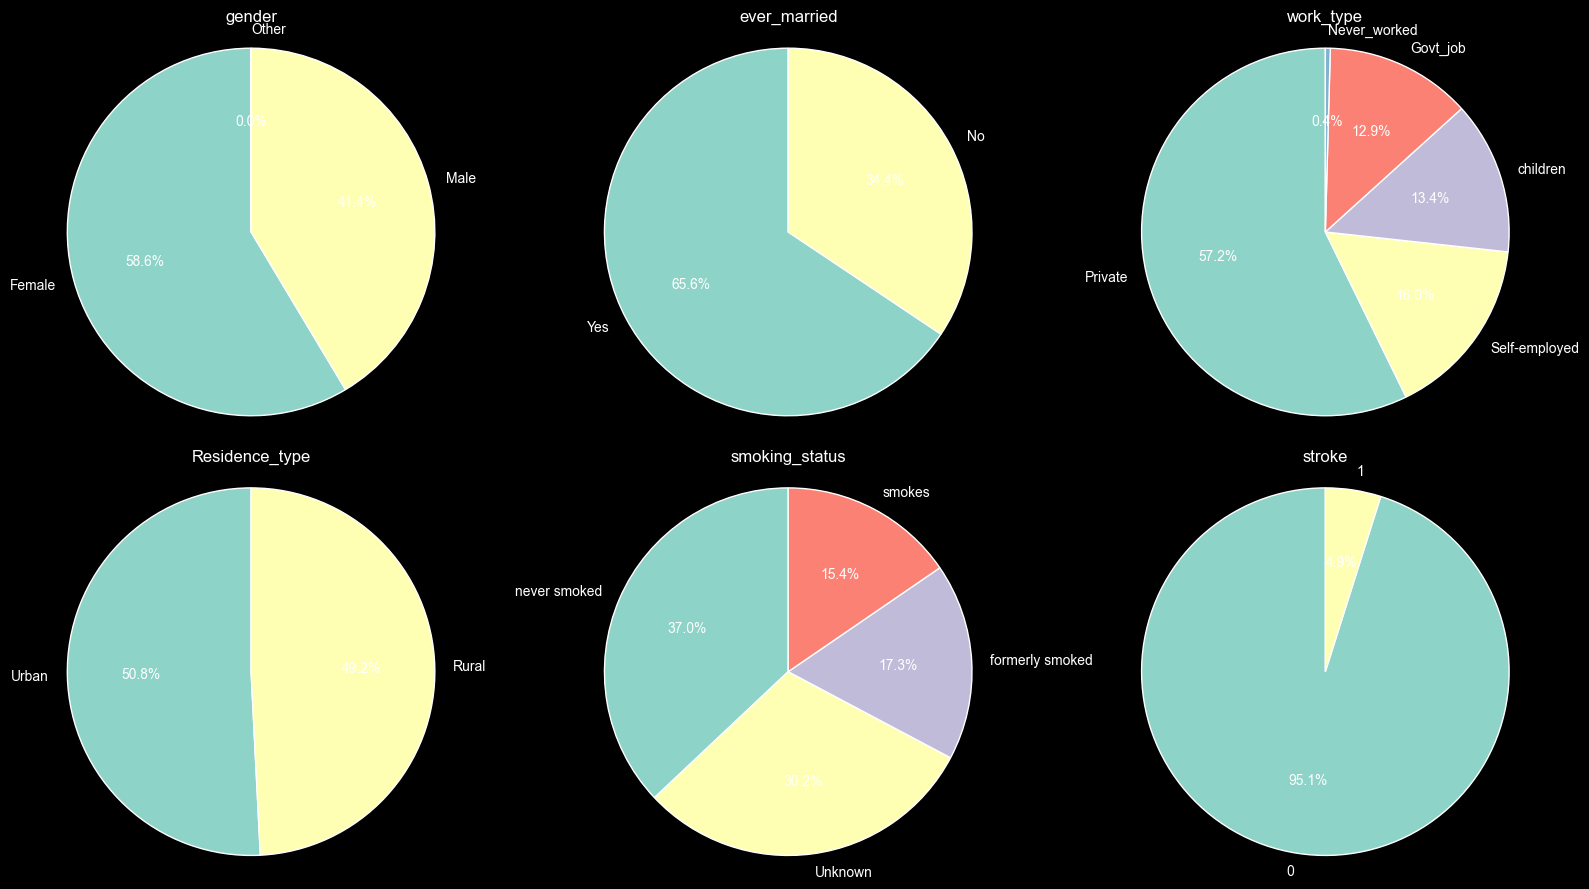

In [17]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 9))
axes = axes.flat

for ax, col in zip(axes, categorical_features):
    sizes = data[col].value_counts()
    labels = sizes.index.astype(str)

    ax.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
    ax.set_title(col)
    ax.axis("equal")

plt.tight_layout()
plt.show()

In [18]:
categorical_features.remove('stroke')
data = pd.get_dummies(data, columns=categorical_features, drop_first=True, dtype=float)
data = data.drop('id', axis=1)

{'name': 'g-bajon', 'alpha_eff': 0.006666666666666667, 'df': 5108.0, 't_crit': 2.7141624772138377, 'r_crit': 0.03794874842143455, 'steps': 10, 'side_left': 123, 'side_right': 123, 'N': 5110.0}


/Users/dominikmika/PycharmProjects/Ridge-hillclimbing/custom_map.py:37: UserWarning: Overwriting the cmap 'g-bajon' that was already in the registry.
  mpl.colormaps.register(my_cmap, force=True)


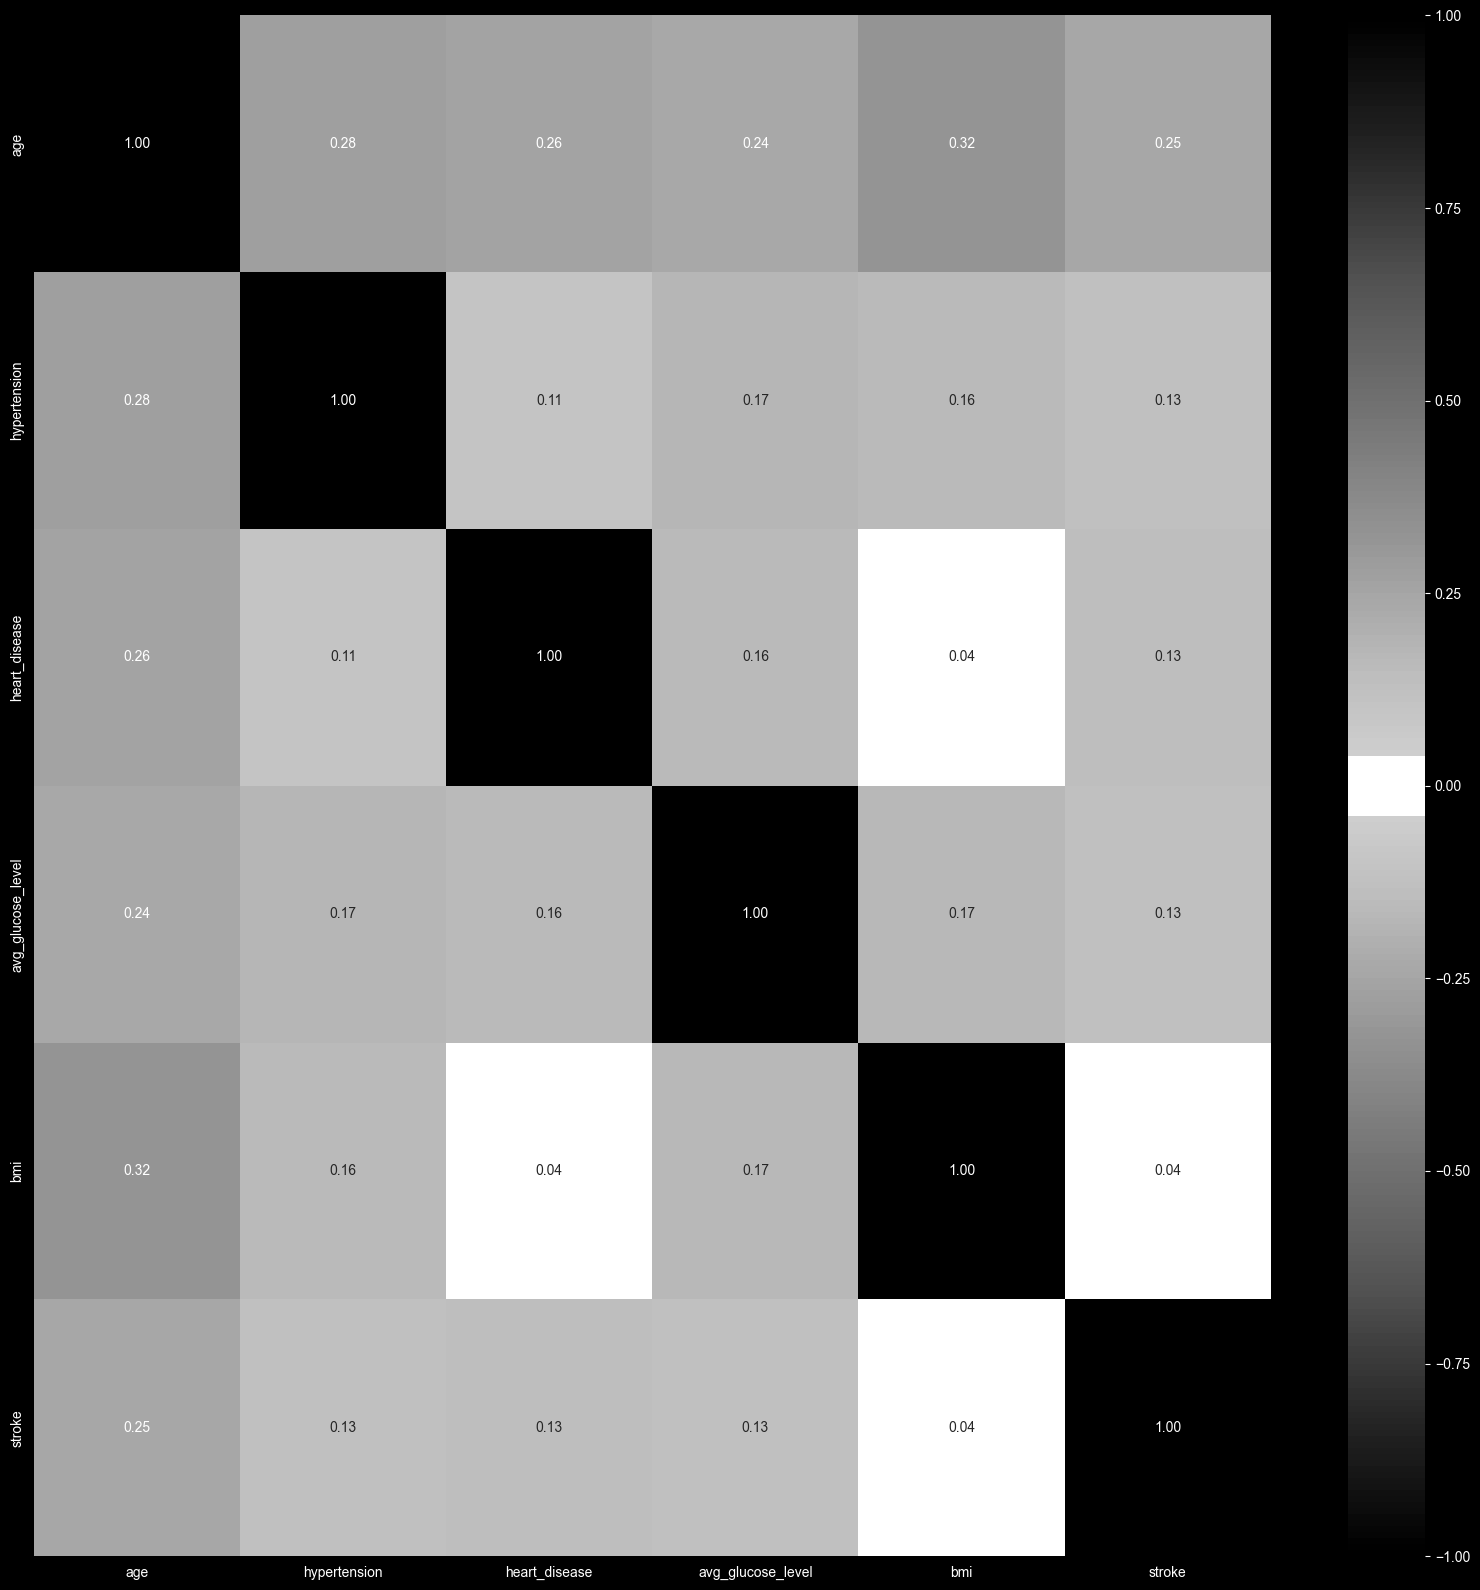

In [19]:
correlation_data = data[numerical_features].corr()

n_features = data[numerical_features].shape[1]
n = data[numerical_features].size/data[numerical_features].shape[1]
custom_map.cmap_pearson(n_features, n, 0.1, "g-bajon")
print(custom_map.cmap_pearson(n_features, n, 0.1, "g-bajon"))

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_data, annot=True, fmt=".2f", cmap="g-bajon", vmin=-1, vmax=1) #tab20b
plt.tight_layout()
plt.show()

{'name': 'g-bajon', 'alpha_eff': 0.006666666666666667, 'df': 5108.0, 't_crit': 2.7141624772138377, 'r_crit': 0.03794874842143455, 'steps': 10, 'side_left': 123, 'side_right': 123, 'N': 5110.0}


/Users/dominikmika/PycharmProjects/Ridge-hillclimbing/custom_map.py:37: UserWarning: Overwriting the cmap 'g-bajon' that was already in the registry.
  mpl.colormaps.register(my_cmap, force=True)


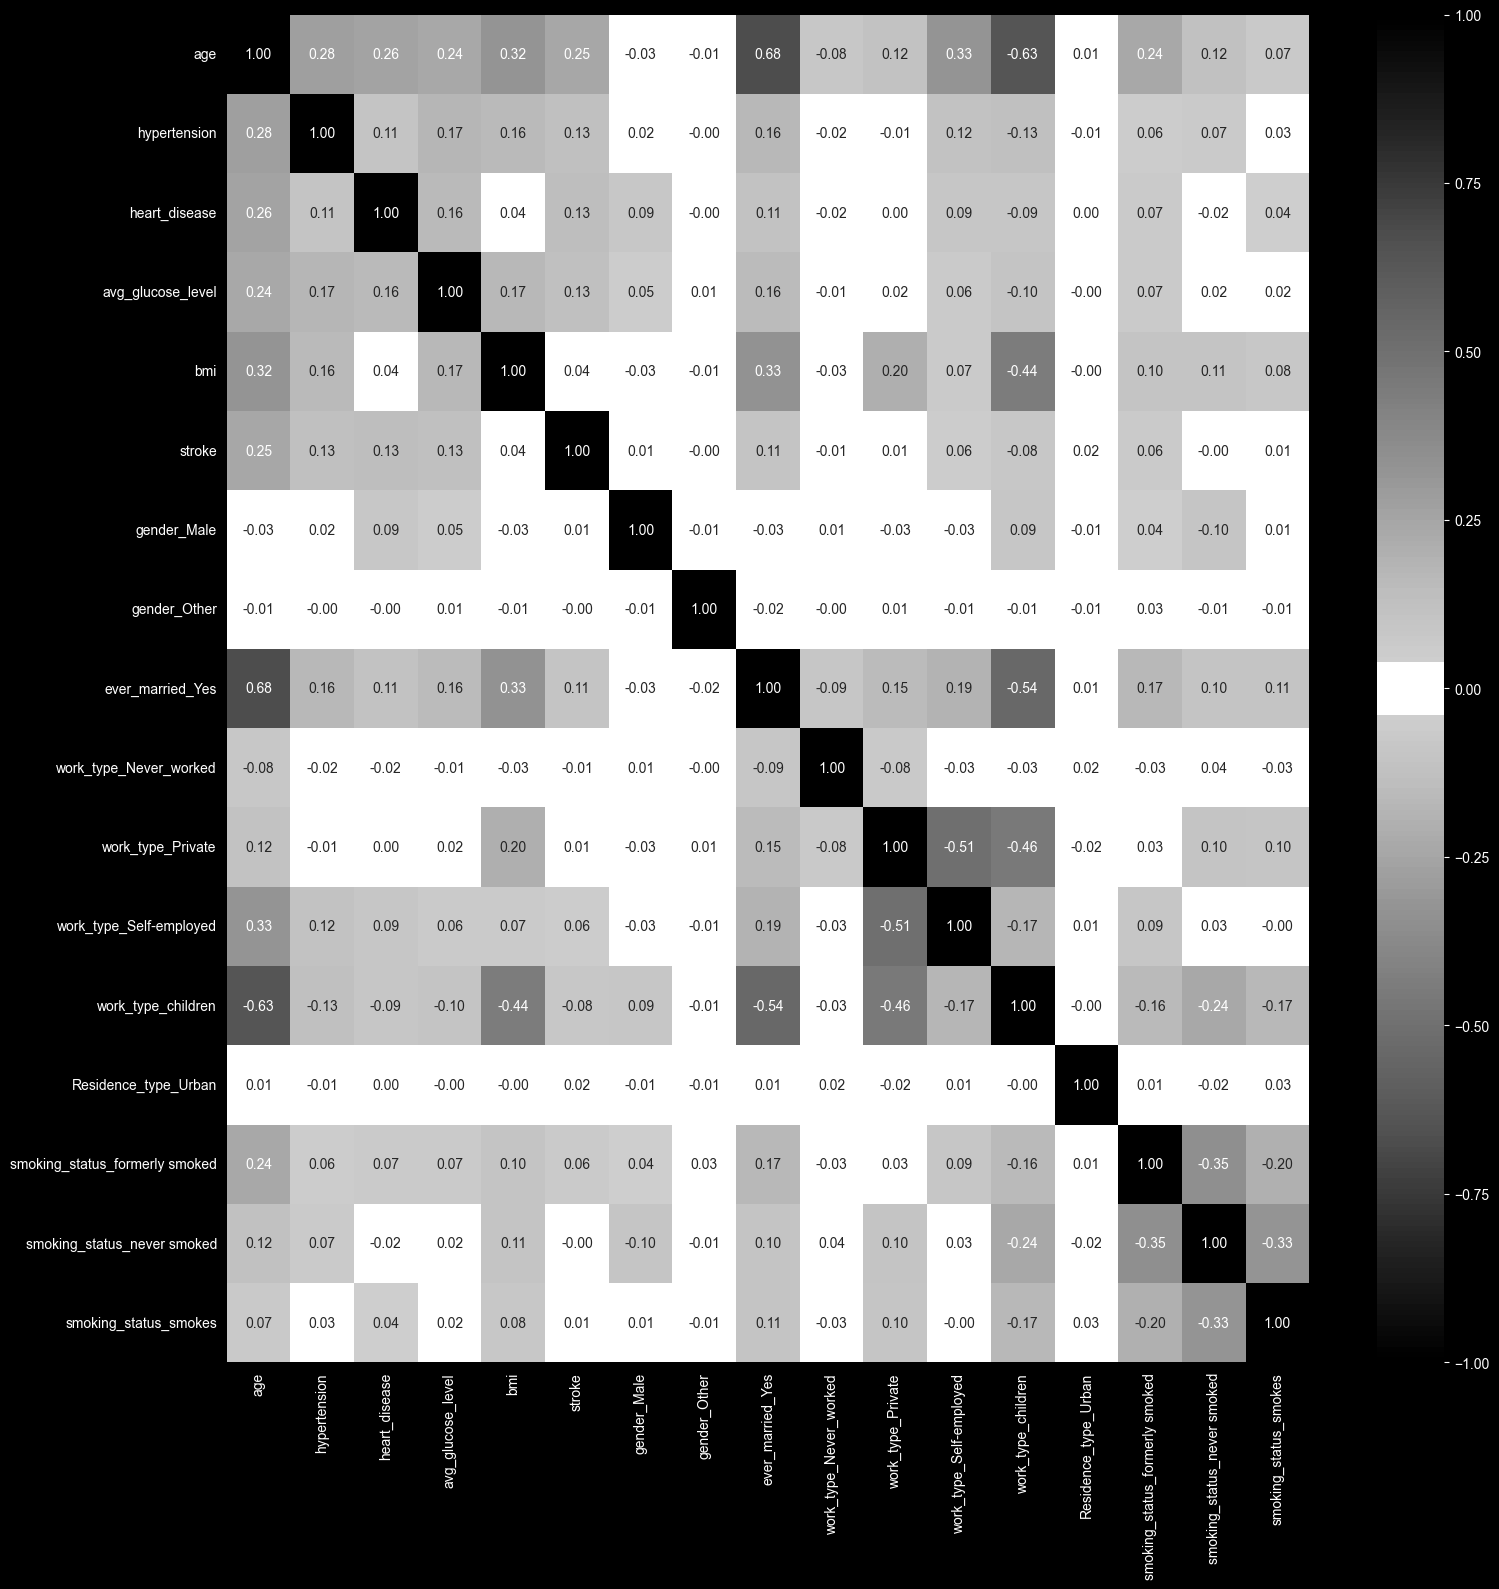

In [20]:
correlation_data = data.corr()

n_features = data[numerical_features].shape[1]
n = data[numerical_features].size/data[numerical_features].shape[1]
custom_map.cmap_pearson(n_features, n, 0.1, "g-bajon")
print(custom_map.cmap_pearson(n_features, n, 0.1, "g-bajon"))

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_data, annot=True, fmt=".2f", cmap="g-bajon", vmin=-1, vmax=1) #tab20b #bajon
plt.tight_layout()
plt.show()

In [21]:
X = data.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Feature selection

In [22]:
rf = RandomForestClassifier(
    n_estimators=500,
    n_jobs=-1,
    class_weight="balanced",
)

boruta = BorutaPy(
    estimator=rf,
    n_estimators='auto',   # lub liczba
    max_iter=100,
    alpha=0.05
)

boruta.fit(X_train, y_train)

selected_mask = boruta.support_
selected_features = np.where(selected_mask)[0]
print("Wybrane cechy (indeksy):", selected_features)
print("Ranking:", boruta.ranking_)

Wybrane cechy (indeksy): [0 3 4]
Ranking: [ 1  3  4  1  1  9 14  2 13 10  5 10  6  8  6 12]


In [23]:
selected_indices = np.where(boruta.support_)[0]
boruta_features = X_train.columns[selected_indices].tolist()

boruta_features

['age', 'avg_glucose_level', 'bmi']

In [24]:
corr_features = data.corr()[target].sort_values(ascending=False)
corr_features = corr_features[corr_features > custom_map.cmap_pearson(n_features, n, 0.1)['r_crit']].index.tolist()

corr_features.remove('stroke')
corr_features

/Users/dominikmika/PycharmProjects/Ridge-hillclimbing/custom_map.py:37: UserWarning: Overwriting the cmap 'g-bajon' that was already in the registry.
  mpl.colormaps.register(my_cmap, force=True)


['age',
 'heart_disease',
 'avg_glucose_level',
 'hypertension',
 'ever_married_Yes',
 'smoking_status_formerly smoked',
 'work_type_Self-employed']

In [25]:
data[corr_features].head()

,age,heart_disease,avg_glucose_level,hypertension,ever_married_Yes,smoking_status_formerly smoked,work_type_Self-employed
0,67.0,1,228.69,0,1.0,1.0,0.0
1,61.0,0,202.21,0,1.0,0.0,1.0
2,80.0,1,105.92,0,1.0,0.0,0.0
3,49.0,0,171.23,0,1.0,0.0,0.0
4,79.0,0,174.12,1,1.0,0.0,1.0


In [26]:
X_chosen = data[corr_features].copy()
X_scaled = scaler.fit_transform(X_chosen)

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=20
)

clusters = kmeans.fit_predict(X_scaled)
X_chosen["cluster"] = clusters

X_chosen["cluster"].describe()

count    5110.000000
mean        0.429159
std         0.594200
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: cluster, dtype: float64

In [27]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 4088 entries, 1905 to 2020
Series name: stroke
Non-Null Count  Dtype
--------------  -----
4088 non-null   int64
dtypes: int64(1)
memory usage: 63.9 KB


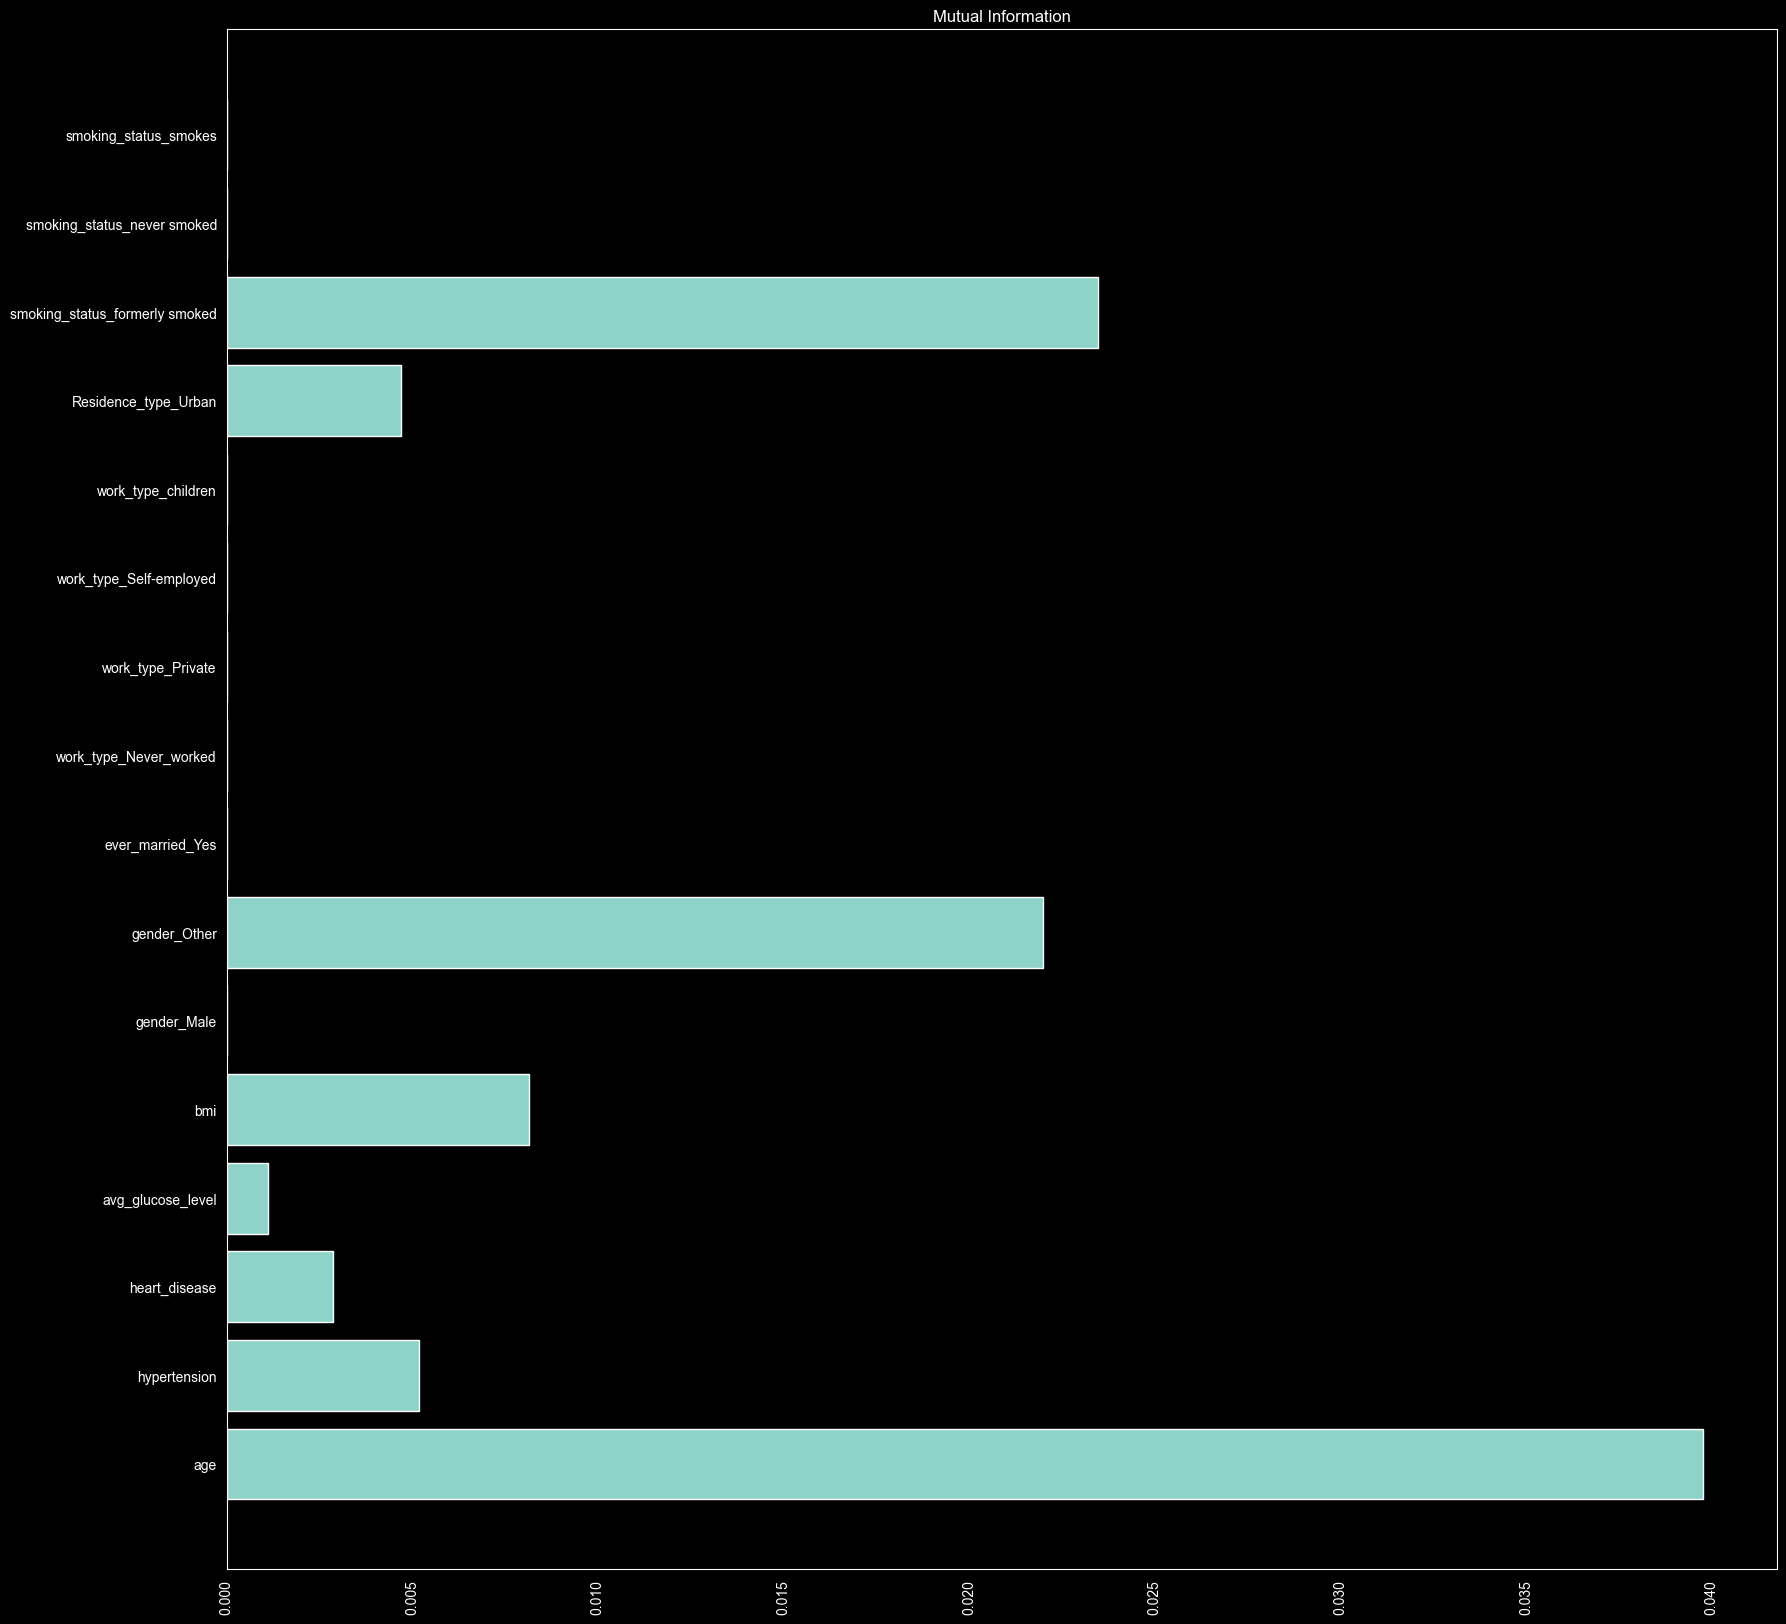

,Feature,Mutual Information
0,age,0.039765
1,hypertension,0.005191
2,heart_disease,0.002876
3,avg_glucose_level,0.001124
4,bmi,0.008134
5,gender_Male,0.000000
6,gender_Other,0.021998
7,ever_married_Yes,0.000000
8,work_type_Never_worked,0.000000
9,work_type_Private,0.000000


In [28]:
sample_idx = np.random.choice(len(X_train), size=int(X_train.size/20), replace=False)

mi = mutual_info_regression(X_train.iloc[sample_idx], y_train.iloc[sample_idx])
mi_df = pd.DataFrame({"Feature": X_train.columns, "Mutual Information": mi})

plt.figure(figsize=(20, 20))
plt.barh(X_train.columns, mi)
plt.grid(False)
plt.xticks(rotation=90)
plt.title('Mutual Information')
plt.show()
mi_df



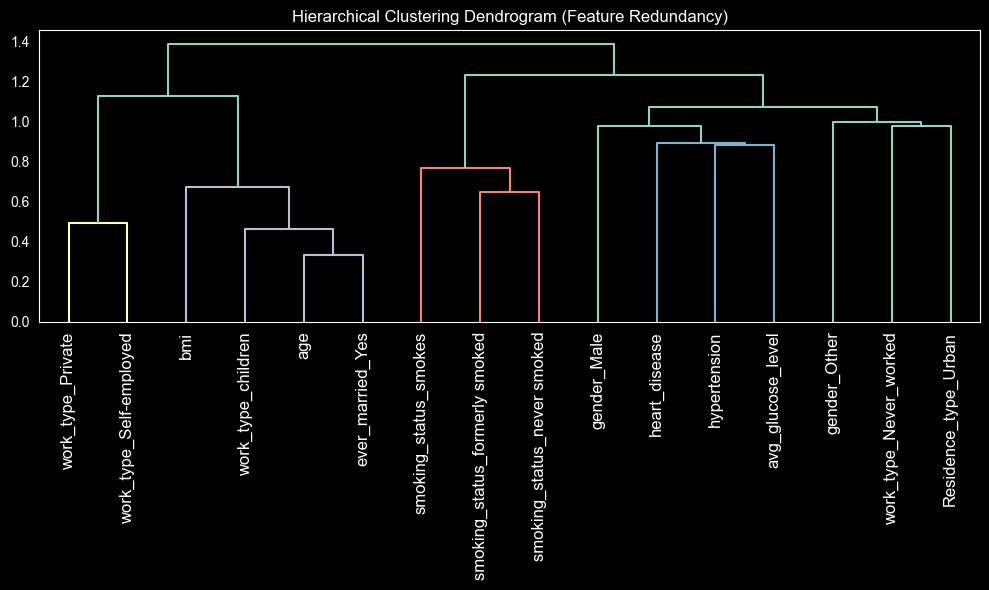

Original features: 16
Reduced features: 5
Selected: Index(['age', 'hypertension', 'gender_Other', 'work_type_Private',
       'smoking_status_formerly smoked'],
      dtype='object')


In [29]:
names = X_train.columns
# 1. Compute Spearman correlation and distance matrix
# Assuming X is your dataframe of explanatory variables
corr = spearmanr(X).correlation
# Ensure the matrix is symmetric (sometimes float errors occur)
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# Convert correlation to a distance matrix
dist_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(hierarchy.distance.squareform(dist_matrix))

# 2. Visualize the Dendrogram
fig, ax = plt.subplots(figsize=(10, 6))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=names, ax=ax, leaf_rotation=90
)
ax.set_title("Hierarchical Clustering Dendrogram (Feature Redundancy)")
plt.tight_layout()
plt.grid(False)
plt.show()

# 3. Select Features
# Threshold '1' is common for 1 - abs(corr), but you can adjust based on the plot
cluster_ids = hierarchy.fcluster(dist_linkage, t=1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

# Keep only the first feature from each cluster
selected_idx = [v[0] for v in cluster_id_to_feature_ids.values()]
mi_features = names[selected_idx]
X_reduced = X_train.iloc[:, selected_idx]


print(f"Original features: {X_train.shape[1]}")
print(f"Reduced features: {len(mi_features)}")
print(f"Selected: {mi_features}")

In [30]:
def calculate_vif(df: pd.DataFrame):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns

    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    print(vif_data)

In [31]:
calculate_vif(X_train.drop(columns=["age", "bmi"]))

                           feature       VIF
0                     hypertension  1.180810
1                    heart_disease  1.109875
2                avg_glucose_level  5.635485
3                      gender_Male  1.719015
4                     gender_Other       NaN
5                 ever_married_Yes  3.776810
6           work_type_Never_worked  1.026110
7                work_type_Private  3.670619
8          work_type_Self-employed  1.840047
9               work_type_children  1.621073
10            Residence_type_Urban  1.913857
11  smoking_status_formerly smoked  1.757536
12     smoking_status_never smoked  2.451698
13           smoking_status_smokes  1.643114


/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [32]:
vif_features = X_train.drop(columns=["age", "bmi"]).columns.tolist()
vif_features

['hypertension',
 'heart_disease',
 'avg_glucose_level',
 'gender_Male',
 'gender_Other',
 'ever_married_Yes',
 'work_type_Never_worked',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'Residence_type_Urban',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes']

In [33]:
model = LogisticRegression(
    solver="lbfgs",
    max_iter=10000,
    class_weight="balanced",
    random_state=42
)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(5),
    scoring="roc_auc",
    min_features_to_select=3
)

rfecv.fit(X_train_scaled, y_train)

rfe_features = X_train.columns[rfecv.support_].tolist()
ranking = pd.DataFrame({
    "feature": X_train.columns,
    "rank": rfecv.ranking_
}).sort_values("rank")

print("Liczba wybranych cech:", len(rfe_features))
print("Wybrane cechy:")
print(rfe_features)

Liczba wybranych cech: 15
Wybrane cechy:
['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Male', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


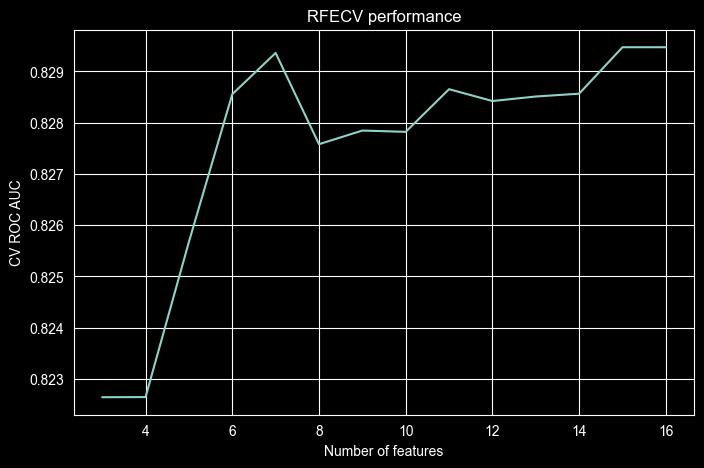

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(
    range(rfecv.min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + rfecv.min_features_to_select),
    rfecv.cv_results_["mean_test_score"]
)
plt.xlabel("Number of features")
plt.ylabel("CV ROC AUC")
plt.title("RFECV performance")
plt.grid(True)
plt.show()


## Model training

In [35]:
## hard coding because of stochasticity

all_features = ["age", "hypertension", "heart_disease", "avg_glucose_level",
                "bmi", "gender_Male", "gender_Other", "ever_married_Yes",
                "work_type_Never_worked", "work_type_Private", "work_type_Self-employed",
                "work_type_children", "Residence_type_Urban",
                "smoking_status_formerly smoked", "smoking_status_never smoked",
                "smoking_status_smokes"]

boruta_features = ["age", "avg_glucose_level", "bmi"]

corr_features = ["age", "heart_disease", "avg_glucose_level", "hypertension",
                 "ever_married_Yes", "smoking_status_formerly smoked",
                 "work_type_Self-employed"]

mi_features = ["age", "hypertension", "gender_Other",
               "work_type_Private", "smoking_status_formerly smoked"]

rfe_features = ["age", "hypertension", "heart_disease", "avg_glucose_level",
                "bmi", "work_type_Never_worked", "work_type_children",
                "Residence_type_Urban", "smoking_status_never smoked",
                "smoking_status_smokes"]

FEATURE_SETS = {
    "all": all_features,
    "boruta": boruta_features,
    "correlation": corr_features,
    "mi": mi_features,
    "rfe": rfe_features
}

In [36]:
X_train_all = X_train[all_features] # all features
X_train_boruta = X_train[boruta_features].copy() # boruta selection
X_train_corr = X_train[corr_features].copy() # cmap correlation
X_train_mi = X_train[mi_features].copy() # correlation, mi & clustering
X_train_rfe = X_train[rfe_features].copy() # rfecv

data = {
    "Method": [
        "All features",
        "Boruta",
        "Corelation",
        "Mutual Information",
        "RFE"
    ],
    "Feature quantity": [
        len(all_features),
        len(boruta_features),
        len(corr_features),
        len(mi_features),
        len(rfe_features)
    ],
    "Feature name": [
        ", ".join(all_features),
        ", ".join(boruta_features),
        ", ".join(corr_features),
        ", ".join(mi_features),
        ", ".join(rfe_features)
    ]
}

pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)
df = pd.DataFrame(data)
df

,Method,Feature quantity,Feature name
0,All features,16,"age, hypertension, heart_disease, avg_glucose_level, bmi, gender_Male, gender_Other, ever_married_Yes, work_type_Never_worked, work_type_Private, work_type_Self-employed, work_type_children, Residence_type_Urban, smoking_status_formerly smoked, smoking_status_never smoked, smoking_status_smokes"
1,Boruta,3,"age, avg_glucose_level, bmi"
2,Corelation,7,"age, heart_disease, avg_glucose_level, hypertension, ever_married_Yes, smoking_status_formerly smoked, work_type_Self-employed"
3,Mutual Information,5,"age, hypertension, gender_Other, work_type_Private, smoking_status_formerly smoked"
4,RFE,10,"age, hypertension, heart_disease, avg_glucose_level, bmi, work_type_Never_worked, work_type_children, Residence_type_Urban, smoking_status_never smoked, smoking_status_smokes"


In [37]:
storage_url = "sqlite:///optuna_studies.db"
cv = StratifiedKFold(5, shuffle=True, random_state=42)

MODELS = [
    "logreg", "knn", "svm", "gnb", "dt",
    "rf", "ada", "gb", "extra",
    "lgbm", "xgb", "cat"
]

SMOTE_MODELS = {"logreg", "knn", "svm", "gnb"}

In [38]:
def sanitize_params(model, params):
    #valid = model.get_params().keys()
    #return {k: v for k, v in params.items() if k in valid}

    valid_params = set(model.get_params().keys())

    clean = {}
    for k, v in params.items():
        if k in valid_params:
            clean[k] = v
        else:
            # jawnie ignorujemy parametry pomocnicze Optuny
            if not k.startswith("smote"):
                pass  # można tu dodać logging jeśli chcesz

    return clean


In [39]:
def get_model_base(name, pos_weight=None):

    use_smote = name in SMOTE_MODELS

    def make_smote():
        return BorderlineSMOTE(
            sampling_strategy=0.3,
            random_state=42
        )

    if name == "logreg":
        steps = [("scaler", StandardScaler())]
        if use_smote:
            steps.append(("smote", make_smote()))
        steps.append((
            "clf",
            LogisticRegression(
                solver="saga",
                C=1.0,
                max_iter=5000,
                class_weight=None if use_smote else "balanced",
                random_state=42
            )
        ))
        return ImbPipeline(steps)

    if name == "knn":
        steps = [("scaler", StandardScaler())]
        if use_smote:
            steps.append(("smote", make_smote()))
        steps.append((
            "clf",
            KNeighborsClassifier(
                n_neighbors=15,
                weights="distance"
            )
        ))
        return ImbPipeline(steps)

    if name == "svm":
        steps = [("scaler", StandardScaler())]
        if use_smote:
            steps.append(("smote", make_smote()))
        steps.append((
            "clf",
            SVC(
                C=1.0,
                kernel="rbf",
                probability=True,
                class_weight=None if use_smote else "balanced",
                random_state=42
            )
        ))
        return ImbPipeline(steps)

    if name == "gnb":
        steps = [("scaler", StandardScaler())]
        if use_smote:
            steps.append(("smote", make_smote()))
        steps.append(("clf", GaussianNB()))
        return ImbPipeline(steps)

    if name == "dt":
        return DecisionTreeClassifier(
            max_depth=6,
            min_samples_leaf=20,
            class_weight="balanced",
            random_state=42
        )

    if name == "rf":
        return RandomForestClassifier(
            n_estimators=500,
            min_samples_leaf=5,
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        )

    if name == "extra":
        return ExtraTreesClassifier(
            n_estimators=500,
            min_samples_leaf=5,
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        )

    if name == "ada":
        return AdaBoostClassifier(
            n_estimators=300,
            learning_rate=0.05,
            random_state=42
        )

    if name == "gb":
        return GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        )

    if name == "lgbm":
        return LGBMClassifier(
            n_estimators=500,
            learning_rate=0.05,
            class_weight="balanced",
            random_state=42
        )

    if name == "xgb":
        return XGBClassifier(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=pos_weight,
            eval_metric="logloss",
            tree_method="hist",
            random_state=42
        )

    if name == "cat":
        return CatBoostClassifier(
            iterations=500,
            depth=6,
            learning_rate=0.05,
            loss_function="Logloss",
            auto_class_weights="Balanced",
            verbose=False,
            random_seed=42
        )

    raise ValueError(name)


In [40]:
def get_model_search(trial, name):

    use_smote = name in SMOTE_MODELS

    def make_smote():
        return BorderlineSMOTE(
            sampling_strategy=0.3,
            random_state=42
        )

    # =====================================================
    # LINEAR / DISTANCE MODELS
    # =====================================================

    if name == "logreg":
        steps = [("scaler", StandardScaler())]

        if use_smote:
            steps.append(("smote", make_smote()))

        steps.append((
            "clf",
            LogisticRegression(
                penalty="elasticnet",
                solver="saga",
                C=trial.suggest_float("clf__C", 1e-3, 10, log=True),
                l1_ratio=trial.suggest_float("clf__l1_ratio", 0.0, 1.0),
                class_weight=None if use_smote else "balanced",
                max_iter=5000,
                random_state=42
            )
        ))

        return ImbPipeline(steps)

    if name == "knn":
        steps = [("scaler", StandardScaler())]

        if use_smote:
            steps.append(("smote", make_smote()))

        steps.append((
            "clf",
            KNeighborsClassifier(
                n_neighbors=trial.suggest_int("clf__n_neighbors", 3, 25),
                weights=trial.suggest_categorical(
                    "clf__weights", ["uniform", "distance"]
                )
            )
        ))

        return ImbPipeline(steps)

    if name == "svm":
        steps = [("scaler", StandardScaler())]

        if use_smote:
            steps.append(("smote", make_smote()))

        steps.append((
            "clf",
            SVC(
                C=trial.suggest_float("clf__C", 1e-2, 10, log=True),
                kernel="rbf",
                probability=True,
                class_weight=None if use_smote else "balanced",
                random_state=42
            )
        ))

        return ImbPipeline(steps)

    if name == "gnb":
        steps = [("scaler", StandardScaler())]

        if use_smote:
            steps.append(("smote", make_smote()))

        steps.append((
            "clf",
            GaussianNB(
                var_smoothing=trial.suggest_float(
                    "clf__var_smoothing", 1e-12, 1e-8, log=True
                )
            )
        ))

        return ImbPipeline(steps)

    # =====================================================
    # TREE MODELS (NO SMOTE)
    # =====================================================

    if name == "dt":
        return DecisionTreeClassifier(
            max_depth=trial.suggest_int("max_depth", 2, 15),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
            class_weight="balanced",
            random_state=42
        )

    if name == "rf":
        return RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 200, 600),
            max_depth=trial.suggest_int("max_depth", 3, 15),
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        )

    if name == "extra":
        return ExtraTreesClassifier(
            n_estimators=trial.suggest_int("n_estimators", 200, 600),
            max_depth=trial.suggest_int("max_depth", 3, 15),
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        )

    if name == "ada":
        return AdaBoostClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 400),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 1.0),
            random_state=42
        )

    if name == "gb":
        return GradientBoostingClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 400),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2),
            max_depth=trial.suggest_int("max_depth", 2, 5),
            random_state=42
        )

    if name == "lgbm":
        return LGBMClassifier(
            n_estimators=trial.suggest_int("n_estimators", 200, 600),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2),
            num_leaves=trial.suggest_int("num_leaves", 16, 64),
            class_weight="balanced",
            random_state=42
        )

    if name == "xgb":
        return XGBClassifier(
            n_estimators=trial.suggest_int("n_estimators", 200, 600),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2),
            subsample=trial.suggest_float("subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
            eval_metric="logloss",
            tree_method="hist",
            random_state=42
        )

    raise ValueError(name)


In [41]:
def objective_catboost(trial, X, y):

    params = {
        "iterations": trial.suggest_int("iterations", 200, 600),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "loss_function": "Logloss",
        "auto_class_weights": "Balanced",
        "verbose": False,
        "random_seed": 42
    }

    f1s = []

    for tr, va in cv.split(X, y):
        model = CatBoostClassifier(**params)
        model.fit(X.iloc[tr], y.iloc[tr])
        preds = model.predict(X.iloc[va])
        f1s.append(f1_score(y.iloc[va], preds))

    return np.mean(f1s)

In [42]:
def get_model_final(name, params, pos_weight=None):
    model = get_model_base(name, pos_weight=pos_weight)

    clean_params = sanitize_params(model, params)

    model.set_params(**clean_params)
    return model


In [43]:
def objective(trial, model_name, X, y):
    model = get_model_search(trial, model_name)

    scores = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring="f1",
        n_jobs=-1
    )

    return scores.mean()


In [44]:
os.makedirs("models", exist_ok=True)

N_TRIALS = 50

for fs_name, feature_list in FEATURE_SETS.items():

    X_fs = X_train[feature_list].copy()

    print(f"\n===== FEATURE SET: {fs_name} | {X_fs.shape[1]} features =====")

    for model_name in MODELS:

        study_name = f"{model_name}_{fs_name}_f1"

        print(f"\n--- Optimizing: {study_name} ---")

        study = optuna.create_study(
            study_name=study_name,
            storage=storage_url,
            direction="maximize",
            load_if_exists=True
        )

        study.optimize(
            lambda trial: objective(trial, model_name, X_fs, y_train),
            n_trials=N_TRIALS,
            show_progress_bar=True
        )

        best_params = study.best_params
        best_f1 = study.best_value

        print(
            f"✔ Best F1 | {model_name} | {fs_name}: {best_f1:.4f}"
        )

        # ===== FINAL MODEL =====
        final_model = get_model_final(
            model_name,
            best_params
        )

        final_model.fit(X_fs, y_train)

        model_path = (
            f"models/"
            f"{model_name}_{fs_name}_final_f1_{best_f1:.4f}.pkl"
        )

        with open(model_path, "wb") as f:
            pickle.dump(final_model, f)

        print(f"💾 Saved -> {model_path}")


===== FEATURE SET: all | 16 features =====

--- Optimizing: logreg_all_f1 ---


[I 2026-01-12 15:58:03,534] Using an existing study with name 'logreg_all_f1' instead of creating a new one.
  0%|          | 0/50 [00:00<?, ?it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.w

[I 2026-01-12 15:58:05,171] Trial 100 finished with value: 0.0 and parameters: {'clf__C': 0.0010932898044464763, 'clf__l1_ratio': 0.9762426947612056}. Best is trial 64 with value: 0.2537940838376995.


/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
Best trial: 64. Best value: 0.253794:   4%|▍         | 2/50 [00:02<00:57,  1.20s/it]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.

[I 2026-01-12 15:58:06,063] Trial 101 finished with value: 0.23680299912767272 and parameters: {'clf__C': 0.1529809353124624, 'clf__l1_ratio': 0.8403370805960043}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:06,113] Trial 102 finished with value: 0.2321774646431196 and parameters: {'clf__C': 0.06840754382279723, 'clf__l1_ratio': 0.8984137819852098}. Best is trial 64 with value: 0.2537940838376995.


/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
Best trial: 64. Best value: 0.253794:   8%|▊         | 4/50 [00:03<00:32,  1.40it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.

[I 2026-01-12 15:58:06,919] Trial 103 finished with value: 0.2398079208885036 and parameters: {'clf__C': 0.13164135263641935, 'clf__l1_ratio': 0.9403738838206943}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:06,970] Trial 104 finished with value: 0.23944239315526894 and parameters: {'clf__C': 0.18773322263505884, 'clf__l1_ratio': 0.8616487856335745}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:07,007] Trial 105 finished with value: 0.23051254410938204 and parameters: {'clf__C': 0.07774563079105108, 'clf__l1_ratio': 0.8028593354710615}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:07,045] Trial 106 finished with value: 0.23636124086716973 and parameters: {'clf__C': 0.10454764348566324, 'clf__l1_ratio': 0.9066297469826666}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:07,083] Trial 107 finished with value: 0.23944239315526894 and parameters: {'clf__C': 0.17042301147931224, 'clf__l1_ratio': 0

Best trial: 64. Best value: 0.253794:  16%|█▌        | 8/50 [00:03<00:13,  3.04it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.

[I 2026-01-12 15:58:07,145] Trial 108 finished with value: 0.24076281573116284 and parameters: {'clf__C': 0.23304743851893556, 'clf__l1_ratio': 0.8845332223517158}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:07,193] Trial 109 finished with value: 0.2400904706276244 and parameters: {'clf__C': 0.28968452625227015, 'clf__l1_ratio': 0.9995296559908164}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:07,230] Trial 110 finished with value: 0.2308895721552505 and parameters: {'clf__C': 0.036199350528266665, 'clf__l1_ratio': 0.8318891693954579}. Best is trial 64 with value: 0.2537940838376995.


/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
Best trial: 64. Best value: 0.253794:  24%|██▍       | 12/50 [00:04<00:10,  3.68it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3

[I 2026-01-12 15:58:08,054] Trial 111 finished with value: 0.2391471781224977 and parameters: {'clf__C': 0.13397263712408833, 'clf__l1_ratio': 0.9635995407033229}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:08,095] Trial 112 finished with value: 0.23951172585546648 and parameters: {'clf__C': 0.12500459685768697, 'clf__l1_ratio': 0.9798344937776123}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:08,133] Trial 113 finished with value: 0.2382582275009267 and parameters: {'clf__C': 0.10060788582584385, 'clf__l1_ratio': 0.9954544523272915}. Best is trial 64 with value: 0.2537940838376995.


/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
Best trial: 64. Best value: 0.253794:  30%|███       | 15/50 [00:05<00:09,  3.56it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3

[I 2026-01-12 15:58:08,939] Trial 114 finished with value: 0.23944337315553482 and parameters: {'clf__C': 0.14146043900963723, 'clf__l1_ratio': 0.9555734595227017}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:08,989] Trial 115 finished with value: 0.23323714775001622 and parameters: {'clf__C': 0.08711839624195547, 'clf__l1_ratio': 0.9132113394776437}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,027] Trial 116 finished with value: 0.23944239315526894 and parameters: {'clf__C': 0.17344723346468124, 'clf__l1_ratio': 0.8544651470303353}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,063] Trial 117 finished with value: 0.233015753210442 and parameters: {'clf__C': 0.059499479164467343, 'clf__l1_ratio': 0.9345895482533446}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,111] Trial 118 finished with value: 0.23271600889691965 and parameters: {'clf__C': 0.05106081607890126, 'clf__l1_ratio': 0

Best trial: 64. Best value: 0.253794:  38%|███▊      | 19/50 [00:05<00:06,  5.14it/s]/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3

[I 2026-01-12 15:58:09,149] Trial 119 finished with value: 0.23716754686064148 and parameters: {'clf__C': 0.1168064173148828, 'clf__l1_ratio': 0.8813161524724951}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,212] Trial 120 finished with value: 0.23870544105715527 and parameters: {'clf__C': 0.2018026678590619, 'clf__l1_ratio': 0.8154134119398464}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,263] Trial 121 finished with value: 0.23980149987729787 and parameters: {'clf__C': 0.1477025586060773, 'clf__l1_ratio': 0.900766481011618}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,300] Trial 122 finished with value: 0.23051254410938204 and parameters: {'clf__C': 0.07930593470686559, 'clf__l1_ratio': 0.8654562402862996}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,335] Trial 123 finished with value: 0.23951172585546648 and parameters: {'clf__C': 0.11824050942352386, 'clf__l1_ratio': 0.95

/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' wa

[I 2026-01-12 15:58:09,396] Trial 124 finished with value: 0.24168215782697552 and parameters: {'clf__C': 0.2187148230519436, 'clf__l1_ratio': 0.9284471902993268}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,432] Trial 125 finished with value: 0.23680299912767272 and parameters: {'clf__C': 0.15444576375718042, 'clf__l1_ratio': 0.8326987584075909}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,469] Trial 126 finished with value: 0.2400904706276244 and parameters: {'clf__C': 0.2758448068482026, 'clf__l1_ratio': 0.8897856019347419}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,504] Trial 127 finished with value: 0.2358886672366296 and parameters: {'clf__C': 0.09021021204813058, 'clf__l1_ratio': 0.9715890221360997}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,540] Trial 128 finished with value: 0.23680299912767272 and parameters: {'clf__C': 0.13725212101929474, 'clf__l1_ratio': 0.79

/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' wa

[I 2026-01-12 15:58:09,620] Trial 130 finished with value: 0.238698998850789 and parameters: {'clf__C': 0.10240762653139782, 'clf__l1_ratio': 0.9443351231823748}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,670] Trial 131 finished with value: 0.23944239315526894 and parameters: {'clf__C': 0.178330271440587, 'clf__l1_ratio': 0.8486317907290739}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,708] Trial 132 finished with value: 0.23716754686064148 and parameters: {'clf__C': 0.12965283290183993, 'clf__l1_ratio': 0.8100707437406527}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,769] Trial 133 finished with value: 0.24076281573116284 and parameters: {'clf__C': 0.22379179393997953, 'clf__l1_ratio': 0.8710335222499378}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,816] Trial 134 finished with value: 0.22797368986339905 and parameters: {'clf__C': 0.1625499126346274, 'clf__l1_ratio': 0.084

/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' wa

[I 2026-01-12 15:58:09,853] Trial 135 finished with value: 0.23716754686064148 and parameters: {'clf__C': 0.11788359307254088, 'clf__l1_ratio': 0.8486491125183886}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,890] Trial 136 finished with value: 0.23161215927561765 and parameters: {'clf__C': 0.09045700941699575, 'clf__l1_ratio': 0.7605649446852988}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,926] Trial 137 finished with value: 0.23980149987729787 and parameters: {'clf__C': 0.15073811767460896, 'clf__l1_ratio': 0.8916391255614443}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:09,962] Trial 138 finished with value: 0.24215371691922427 and parameters: {'clf__C': 0.1924973999267851, 'clf__l1_ratio': 0.9832716428114012}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:10,000] Trial 139 finished with value: 0.2393597416167949 and parameters: {'clf__C': 0.10747594103706444, 'clf__l1_ratio': 0.

/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' wa

[I 2026-01-12 15:58:10,084] Trial 141 finished with value: 0.23716754686064148 and parameters: {'clf__C': 0.14651740226293614, 'clf__l1_ratio': 0.8696171751443591}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:10,142] Trial 142 finished with value: 0.24076281573116284 and parameters: {'clf__C': 0.24078965329065688, 'clf__l1_ratio': 0.9024986767044099}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:10,175] Trial 143 finished with value: 0.23951172585546648 and parameters: {'clf__C': 0.12528059586077783, 'clf__l1_ratio': 0.9489702071816647}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:10,210] Trial 144 finished with value: 0.23051254410938204 and parameters: {'clf__C': 0.07319008395636452, 'clf__l1_ratio': 0.8545882843275678}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:10,261] Trial 145 finished with value: 0.23644389240564373 and parameters: {'clf__C': 0.18029552757444572, 'clf__l1_ratio': 

/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' wa

[I 2026-01-12 15:58:10,333] Trial 146 finished with value: 0.23173150707345663 and parameters: {'clf__C': 0.10191617947098006, 'clf__l1_ratio': 0.5951593656705646}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:10,394] Trial 147 finished with value: 0.23413724383033846 and parameters: {'clf__C': 0.1380507144171949, 'clf__l1_ratio': 0.7767694693598334}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:10,434] Trial 148 finished with value: 0.23323714775001622 and parameters: {'clf__C': 0.08655165879642163, 'clf__l1_ratio': 0.8830400852910218}. Best is trial 64 with value: 0.2537940838376995.
[I 2026-01-12 15:58:10,484] Trial 149 finished with value: 0.2400904706276244 and parameters: {'clf__C': 0.28474879834596384, 'clf__l1_ratio': 0.9142726764858349}. Best is trial 64 with value: 0.2537940838376995.
✔ Best F1 | logreg | all: 0.2538
💾 Saved -> models/logreg_all_final_f1_0.2538.pkl

--- Optimizing: knn_all_f1 ---


[I 2026-01-12 15:58:10,561] Using an existing study with name 'knn_all_f1' instead of creating a new one.
Best trial: 19. Best value: 0.19369:   6%|▌         | 3/50 [00:00<00:03, 14.58it/s]

[I 2026-01-12 15:58:10,634] Trial 100 finished with value: 0.1842307772720133 and parameters: {'clf__n_neighbors': 23, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:10,699] Trial 101 finished with value: 0.175753371837206 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:10,737] Trial 102 finished with value: 0.1362716028905333 and parameters: {'clf__n_neighbors': 10, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:10,787] Trial 103 finished with value: 0.175753371837206 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:  18%|█▊        | 9/50 [00:00<00:01, 22.16it/s]

[I 2026-01-12 15:58:10,836] Trial 104 finished with value: 0.1819347362772849 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:10,873] Trial 105 finished with value: 0.17567499178779666 and parameters: {'clf__n_neighbors': 17, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:10,910] Trial 106 finished with value: 0.18187713156591748 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:10,948] Trial 107 finished with value: 0.175753371837206 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:10,985] Trial 108 finished with value: 0.18138910876215183 and parameters: {'clf__n_neighbors': 21, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,

Best trial: 19. Best value: 0.19369:  28%|██▊       | 14/50 [00:00<00:01, 23.46it/s]

[I 2026-01-12 15:58:11,058] Trial 110 finished with value: 0.18187713156591748 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,097] Trial 111 finished with value: 0.175753371837206 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,153] Trial 112 finished with value: 0.175753371837206 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,191] Trial 113 finished with value: 0.1819347362772849 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,228] Trial 114 finished with value: 0.18187713156591748 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.


Best trial: 19. Best value: 0.19369:  40%|████      | 20/50 [00:00<00:01, 25.53it/s]

[I 2026-01-12 15:58:11,264] Trial 115 finished with value: 0.175753371837206 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,302] Trial 116 finished with value: 0.16904343901262237 and parameters: {'clf__n_neighbors': 22, 'clf__weights': 'distance'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,339] Trial 117 finished with value: 0.17567499178779666 and parameters: {'clf__n_neighbors': 17, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,373] Trial 118 finished with value: 0.1819347362772849 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,410] Trial 119 finished with value: 0.18138910876215183 and parameters: {'clf__n_neighbors': 21, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11

Best trial: 19. Best value: 0.19369:  52%|█████▏    | 26/50 [00:01<00:00, 25.74it/s]

[I 2026-01-12 15:58:11,483] Trial 121 finished with value: 0.175753371837206 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,520] Trial 122 finished with value: 0.175753371837206 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,557] Trial 123 finished with value: 0.18187713156591748 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,603] Trial 124 finished with value: 0.175753371837206 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,640] Trial 125 finished with value: 0.1819347362772849 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,675]

Best trial: 19. Best value: 0.19369:  64%|██████▍   | 32/50 [00:01<00:00, 25.91it/s]

[I 2026-01-12 15:58:11,711] Trial 127 finished with value: 0.175753371837206 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,749] Trial 128 finished with value: 0.1819347362772849 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,794] Trial 129 finished with value: 0.18187713156591748 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,831] Trial 130 finished with value: 0.18138910876215183 and parameters: {'clf__n_neighbors': 21, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,868] Trial 131 finished with value: 0.175753371837206 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,90

Best trial: 19. Best value: 0.19369:  76%|███████▌  | 38/50 [00:01<00:00, 25.43it/s]

[I 2026-01-12 15:58:11,952] Trial 133 finished with value: 0.1819347362772849 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:11,988] Trial 134 finished with value: 0.18187713156591748 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:12,036] Trial 135 finished with value: 0.175753371837206 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:12,071] Trial 136 finished with value: 0.16743939712279185 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'distance'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:12,108] Trial 137 finished with value: 0.1819347362772849 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:12,

Best trial: 19. Best value: 0.19369:  88%|████████▊ | 44/50 [00:01<00:00, 26.90it/s]

[I 2026-01-12 15:58:12,179] Trial 139 finished with value: 0.17567499178779666 and parameters: {'clf__n_neighbors': 17, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:12,215] Trial 140 finished with value: 0.18187713156591748 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:12,251] Trial 141 finished with value: 0.175753371837206 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:12,285] Trial 142 finished with value: 0.1819347362772849 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:12,320] Trial 143 finished with value: 0.175753371837206 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:12,35

Best trial: 19. Best value: 0.19369: 100%|██████████| 50/50 [00:01<00:00, 25.19it/s]
[I 2026-01-12 15:58:12,565] Using an existing study with name 'svm_all_f1' instead of creating a new one.


[I 2026-01-12 15:58:12,402] Trial 145 finished with value: 0.18138910876215183 and parameters: {'clf__n_neighbors': 21, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:12,439] Trial 146 finished with value: 0.1819347362772849 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:12,476] Trial 147 finished with value: 0.18187713156591748 and parameters: {'clf__n_neighbors': 20, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:12,512] Trial 148 finished with value: 0.175753371837206 and parameters: {'clf__n_neighbors': 19, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
[I 2026-01-12 15:58:12,548] Trial 149 finished with value: 0.1819347362772849 and parameters: {'clf__n_neighbors': 18, 'clf__weights': 'uniform'}. Best is trial 19 with value: 0.193690362816545.
✔ Best F1 | knn | all: 0

Best trial: 23. Best value: 0.191398:   2%|▏         | 1/50 [00:00<00:26,  1.87it/s]

[I 2026-01-12 15:58:13,100] Trial 69 finished with value: 0.12768216207968658 and parameters: {'clf__C': 0.07825434563087041}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:   4%|▍         | 2/50 [00:01<00:25,  1.86it/s]

[I 2026-01-12 15:58:13,640] Trial 70 finished with value: 0.15365346495840854 and parameters: {'clf__C': 0.4359381067529715}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:   6%|▌         | 3/50 [00:01<00:24,  1.96it/s]

[I 2026-01-12 15:58:14,120] Trial 71 finished with value: 0.16404649945134211 and parameters: {'clf__C': 0.23831190566010577}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:   8%|▊         | 4/50 [00:02<00:23,  1.97it/s]

[I 2026-01-12 15:58:14,623] Trial 72 finished with value: 0.15997759103641454 and parameters: {'clf__C': 0.218277886644005}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  10%|█         | 5/50 [00:02<00:23,  1.95it/s]

[I 2026-01-12 15:58:15,143] Trial 73 finished with value: 0.15341359143261163 and parameters: {'clf__C': 0.16329679247330792}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  12%|█▏        | 6/50 [00:03<00:25,  1.74it/s]

[I 2026-01-12 15:58:15,836] Trial 74 finished with value: 0.15600544927721005 and parameters: {'clf__C': 0.1224247558319204}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  14%|█▍        | 7/50 [00:03<00:24,  1.74it/s]

[I 2026-01-12 15:58:16,408] Trial 75 finished with value: 0.156754140616046 and parameters: {'clf__C': 0.2766883989054615}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  16%|█▌        | 8/50 [00:04<00:25,  1.64it/s]

[I 2026-01-12 15:58:17,094] Trial 76 finished with value: 0.14758836645934065 and parameters: {'clf__C': 0.38857704414403305}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  18%|█▊        | 9/50 [00:05<00:24,  1.67it/s]

[I 2026-01-12 15:58:17,674] Trial 77 finished with value: 0.1594826357727557 and parameters: {'clf__C': 0.2189980602648474}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  20%|██        | 10/50 [00:05<00:22,  1.75it/s]

[I 2026-01-12 15:58:18,176] Trial 78 finished with value: 0.14509476657733766 and parameters: {'clf__C': 0.6071435909676467}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  22%|██▏       | 11/50 [00:06<00:21,  1.80it/s]

[I 2026-01-12 15:58:18,703] Trial 79 finished with value: 0.15952348902947905 and parameters: {'clf__C': 0.29895836193007946}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  24%|██▍       | 12/50 [00:06<00:20,  1.84it/s]

[I 2026-01-12 15:58:19,222] Trial 80 finished with value: 0.15980735377154814 and parameters: {'clf__C': 0.14914605556568086}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  26%|██▌       | 13/50 [00:07<00:19,  1.88it/s]

[I 2026-01-12 15:58:19,725] Trial 81 finished with value: 0.1531756351344638 and parameters: {'clf__C': 0.194978578906174}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  28%|██▊       | 14/50 [00:07<00:18,  1.91it/s]

[I 2026-01-12 15:58:20,227] Trial 82 finished with value: 0.15547383523370836 and parameters: {'clf__C': 0.2535841632533441}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  30%|███       | 15/50 [00:08<00:18,  1.93it/s]

[I 2026-01-12 15:58:20,733] Trial 83 finished with value: 0.16016300430571104 and parameters: {'clf__C': 0.22304992261177753}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  32%|███▏      | 16/50 [00:08<00:17,  1.98it/s]

[I 2026-01-12 15:58:21,209] Trial 84 finished with value: 0.1499443590267311 and parameters: {'clf__C': 0.47488952991396727}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  34%|███▍      | 17/50 [00:09<00:16,  1.97it/s]

[I 2026-01-12 15:58:21,723] Trial 85 finished with value: 0.15894890377449075 and parameters: {'clf__C': 0.32536336373917135}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  36%|███▌      | 18/50 [00:09<00:16,  1.93it/s]

[I 2026-01-12 15:58:22,261] Trial 86 finished with value: 0.14604898791723567 and parameters: {'clf__C': 0.10390653535592131}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  38%|███▊      | 19/50 [00:10<00:16,  1.93it/s]

[I 2026-01-12 15:58:22,781] Trial 87 finished with value: 0.1590546641594474 and parameters: {'clf__C': 0.1338644144391497}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  40%|████      | 20/50 [00:10<00:15,  1.94it/s]

[I 2026-01-12 15:58:23,289] Trial 88 finished with value: 0.15547383523370836 and parameters: {'clf__C': 0.2565859426922872}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  42%|████▏     | 21/50 [00:11<00:15,  1.90it/s]

[I 2026-01-12 15:58:23,843] Trial 89 finished with value: 0.15173409552045133 and parameters: {'clf__C': 0.1787282551456021}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  44%|████▍     | 22/50 [00:11<00:15,  1.76it/s]

[I 2026-01-12 15:58:24,510] Trial 90 finished with value: 0.0 and parameters: {'clf__C': 0.010232675117777916}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  46%|████▌     | 23/50 [00:12<00:14,  1.84it/s]

[I 2026-01-12 15:58:24,996] Trial 91 finished with value: 0.14796259794824734 and parameters: {'clf__C': 0.38229702842020563}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  48%|████▊     | 24/50 [00:12<00:14,  1.84it/s]

[I 2026-01-12 15:58:25,539] Trial 92 finished with value: 0.15547383523370836 and parameters: {'clf__C': 0.24976401632213827}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  50%|█████     | 25/50 [00:13<00:13,  1.82it/s]

[I 2026-01-12 15:58:26,102] Trial 93 finished with value: 0.1602423751537855 and parameters: {'clf__C': 0.2703041502809632}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  52%|█████▏    | 26/50 [00:14<00:12,  1.89it/s]

[I 2026-01-12 15:58:26,584] Trial 94 finished with value: 0.15010924792832228 and parameters: {'clf__C': 0.576451890470371}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  54%|█████▍    | 27/50 [00:14<00:12,  1.87it/s]

[I 2026-01-12 15:58:27,133] Trial 95 finished with value: 0.15321884946571776 and parameters: {'clf__C': 0.16438999900995507}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  56%|█████▌    | 28/50 [00:15<00:11,  1.90it/s]

[I 2026-01-12 15:58:27,638] Trial 96 finished with value: 0.15457915587533108 and parameters: {'clf__C': 0.3043563641624897}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  58%|█████▊    | 29/50 [00:15<00:11,  1.90it/s]

[I 2026-01-12 15:58:28,159] Trial 97 finished with value: 0.1538226074128711 and parameters: {'clf__C': 0.20680347159133072}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  60%|██████    | 30/50 [00:16<00:10,  1.93it/s]

[I 2026-01-12 15:58:28,662] Trial 98 finished with value: 0.15521124319301677 and parameters: {'clf__C': 0.36883680442993977}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  62%|██████▏   | 31/50 [00:16<00:09,  1.97it/s]

[I 2026-01-12 15:58:29,144] Trial 99 finished with value: 0.15365346495840854 and parameters: {'clf__C': 0.44184913234484563}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  64%|██████▍   | 32/50 [00:17<00:09,  1.87it/s]

[I 2026-01-12 15:58:29,740] Trial 100 finished with value: 0.15145359061161542 and parameters: {'clf__C': 0.1782033412690766}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  66%|██████▌   | 33/50 [00:17<00:09,  1.80it/s]

[I 2026-01-12 15:58:30,299] Trial 101 finished with value: 0.15872165435410082 and parameters: {'clf__C': 0.14621189646438143}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  68%|██████▊   | 34/50 [00:18<00:09,  1.74it/s]

[I 2026-01-12 15:58:30,961] Trial 102 finished with value: 0.1574815402277535 and parameters: {'clf__C': 0.34889363760885755}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  70%|███████   | 35/50 [00:18<00:08,  1.79it/s]

[I 2026-01-12 15:58:31,485] Trial 103 finished with value: 0.16404649945134211 and parameters: {'clf__C': 0.2368906939697873}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  72%|███████▏  | 36/50 [00:19<00:07,  1.82it/s]

[I 2026-01-12 15:58:32,016] Trial 104 finished with value: 0.154859660784167 and parameters: {'clf__C': 0.30307857955801554}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  74%|███████▍  | 37/50 [00:19<00:07,  1.84it/s]

[I 2026-01-12 15:58:32,536] Trial 105 finished with value: 0.15867607085117347 and parameters: {'clf__C': 0.20923264673250655}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  76%|███████▌  | 38/50 [00:20<00:06,  1.89it/s]

[I 2026-01-12 15:58:33,038] Trial 106 finished with value: 0.1574815402277535 and parameters: {'clf__C': 0.3556969934424566}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  78%|███████▊  | 39/50 [00:20<00:05,  1.97it/s]

[I 2026-01-12 15:58:33,499] Trial 107 finished with value: 0.13706568348016998 and parameters: {'clf__C': 0.6795681227680791}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  80%|████████  | 40/50 [00:21<00:04,  2.02it/s]

[I 2026-01-12 15:58:33,963] Trial 108 finished with value: 0.14536958388291543 and parameters: {'clf__C': 0.5497563150743479}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  82%|████████▏ | 41/50 [00:21<00:04,  2.02it/s]

[I 2026-01-12 15:58:34,458] Trial 109 finished with value: 0.16044743325358043 and parameters: {'clf__C': 0.27355951291672254}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  84%|████████▍ | 42/50 [00:22<00:04,  1.97it/s]

[I 2026-01-12 15:58:34,979] Trial 110 finished with value: 0.163523721258661 and parameters: {'clf__C': 0.23505798604121392}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  86%|████████▌ | 43/50 [00:23<00:03,  1.87it/s]

[I 2026-01-12 15:58:35,586] Trial 111 finished with value: 0.1531751519391876 and parameters: {'clf__C': 0.11797595741549492}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  88%|████████▊ | 44/50 [00:23<00:03,  1.84it/s]

[I 2026-01-12 15:58:36,154] Trial 112 finished with value: 0.1529758349346636 and parameters: {'clf__C': 0.1901087648148478}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  90%|█████████ | 45/50 [00:24<00:02,  1.78it/s]

[I 2026-01-12 15:58:36,759] Trial 113 finished with value: 0.1392173810186517 and parameters: {'clf__C': 0.09140514557923264}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  92%|█████████▏| 46/50 [00:24<00:02,  1.76it/s]

[I 2026-01-12 15:58:37,347] Trial 114 finished with value: 0.1590546641594474 and parameters: {'clf__C': 0.13666469283492808}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  94%|█████████▍| 47/50 [00:25<00:01,  1.74it/s]

[I 2026-01-12 15:58:37,933] Trial 115 finished with value: 0.15361339163241183 and parameters: {'clf__C': 0.16066727390470872}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  96%|█████████▌| 48/50 [00:26<00:01,  1.64it/s]

[I 2026-01-12 15:58:38,627] Trial 116 finished with value: 0.14813794960711263 and parameters: {'clf__C': 0.3976904725027554}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398:  98%|█████████▊| 49/50 [00:26<00:00,  1.73it/s]

[I 2026-01-12 15:58:39,133] Trial 117 finished with value: 0.15894890377449075 and parameters: {'clf__C': 0.3150702863511547}. Best is trial 23 with value: 0.19139787858709184.


Best trial: 23. Best value: 0.191398: 100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


[I 2026-01-12 15:58:39,828] Trial 118 finished with value: 0.13078427070093407 and parameters: {'clf__C': 0.07356713015624126}. Best is trial 23 with value: 0.19139787858709184.
✔ Best F1 | svm | all: 0.1914


[I 2026-01-12 15:58:40,421] Using an existing study with name 'gnb_all_f1' instead of creating a new one.


💾 Saved -> models/svm_all_final_f1_0.1914.pkl

--- Optimizing: gnb_all_f1 ---


Best trial: 51. Best value: 0.13294:   8%|▊         | 4/50 [00:00<00:01, 26.37it/s] 

[I 2026-01-12 15:58:40,463] Trial 50 finished with value: 0.13241287812455518 and parameters: {'clf__var_smoothing': 7.070623618852623e-09}. Best is trial 50 with value: 0.13241287812455518.
[I 2026-01-12 15:58:40,500] Trial 51 finished with value: 0.13293996624980828 and parameters: {'clf__var_smoothing': 8.556311169733905e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:40,536] Trial 52 finished with value: 0.1323165242394849 and parameters: {'clf__var_smoothing': 6.717875357437855e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:40,571] Trial 53 finished with value: 0.1323165242394849 and parameters: {'clf__var_smoothing': 6.459847034441583e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:40,595] Trial 54 finished with value: 0.1322274604681862 and parameters: {'clf__var_smoothing': 6.085741421426779e-09}. Best is trial 51 with value: 0.13293996624980828.


Best trial: 51. Best value: 0.13294:  14%|█▍        | 7/50 [00:00<00:01, 31.26it/s]

[I 2026-01-12 15:58:40,629] Trial 55 finished with value: 0.13020506992869765 and parameters: {'clf__var_smoothing': 2.3501559976552615e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:40,651] Trial 56 finished with value: 0.13025018864732604 and parameters: {'clf__var_smoothing': 2.413647866205772e-09}. Best is trial 51 with value: 0.13293996624980828.


Best trial: 51. Best value: 0.13294:  24%|██▍       | 12/50 [00:00<00:01, 34.15it/s]

[I 2026-01-12 15:58:40,675] Trial 57 finished with value: 0.12959296838609266 and parameters: {'clf__var_smoothing': 1.6115536212325315e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:40,710] Trial 58 finished with value: 0.1323165242394849 and parameters: {'clf__var_smoothing': 6.539160122184885e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:40,733] Trial 59 finished with value: 0.13236319732370067 and parameters: {'clf__var_smoothing': 6.7423509382357996e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:40,757] Trial 60 finished with value: 0.1286113320526678 and parameters: {'clf__var_smoothing': 7.100869267218074e-10}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:40,791] Trial 61 finished with value: 0.1323165242394849 and parameters: {'clf__var_smoothing': 6.626635766748013e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:40,813] Trial 62 finished 

Best trial: 51. Best value: 0.13294:  26%|██▌       | 13/50 [00:00<00:01, 34.15it/s]

[I 2026-01-12 15:58:40,848] Trial 63 finished with value: 0.13259476800521736 and parameters: {'clf__var_smoothing': 7.335410434232153e-09}. Best is trial 51 with value: 0.13293996624980828.


Best trial: 51. Best value: 0.13294:  40%|████      | 20/50 [00:00<00:00, 35.08it/s]

[I 2026-01-12 15:58:40,883] Trial 64 finished with value: 0.13132970163378593 and parameters: {'clf__var_smoothing': 4.125703480322567e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:40,908] Trial 65 finished with value: 0.13047213046395228 and parameters: {'clf__var_smoothing': 2.8361460829459792e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:40,929] Trial 66 finished with value: 0.13241287812455518 and parameters: {'clf__var_smoothing': 7.0157194329119305e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:40,963] Trial 67 finished with value: 0.13155656720109238 and parameters: {'clf__var_smoothing': 4.484533083939228e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:40,985] Trial 68 finished with value: 0.13241287812455518 and parameters: {'clf__var_smoothing': 6.855241435231676e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:41,008] Trial 69 finish

Best trial: 51. Best value: 0.13294:  44%|████▍     | 22/50 [00:00<00:00, 35.08it/s]

[I 2026-01-12 15:58:41,052] Trial 71 finished with value: 0.13241287812455518 and parameters: {'clf__var_smoothing': 6.969174757239226e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:41,076] Trial 72 finished with value: 0.13263741692993133 and parameters: {'clf__var_smoothing': 7.732036107996498e-09}. Best is trial 51 with value: 0.13293996624980828.


Best trial: 51. Best value: 0.13294:  58%|█████▊    | 29/50 [00:00<00:00, 39.78it/s]

[I 2026-01-12 15:58:41,107] Trial 73 finished with value: 0.13168579535941355 and parameters: {'clf__var_smoothing': 4.5827836578926796e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:41,131] Trial 74 finished with value: 0.13263741692993133 and parameters: {'clf__var_smoothing': 7.67649862431765e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:41,152] Trial 75 finished with value: 0.1309359070603143 and parameters: {'clf__var_smoothing': 3.4642668374416744e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:41,173] Trial 76 finished with value: 0.13268020545832687 and parameters: {'clf__var_smoothing': 7.736581025439025e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:41,196] Trial 77 finished with value: 0.1300854803099158 and parameters: {'clf__var_smoothing': 2.175864581612124e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:41,218] Trial 78 finished 

Best trial: 51. Best value: 0.13294:  62%|██████▏   | 31/50 [00:00<00:00, 39.78it/s]

[I 2026-01-12 15:58:41,262] Trial 80 finished with value: 0.1328985075584846 and parameters: {'clf__var_smoothing': 8.343638143374558e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:41,284] Trial 81 finished with value: 0.13268020545832687 and parameters: {'clf__var_smoothing': 7.780930605141175e-09}. Best is trial 51 with value: 0.13293996624980828.


Best trial: 87. Best value: 0.133292:  74%|███████▍  | 37/50 [00:01<00:00, 39.00it/s]

[I 2026-01-12 15:58:41,317] Trial 82 finished with value: 0.1328985075584846 and parameters: {'clf__var_smoothing': 8.394103457754882e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:41,351] Trial 83 finished with value: 0.13276422381640934 and parameters: {'clf__var_smoothing': 8.00962466755791e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:41,372] Trial 84 finished with value: 0.1262646586420003 and parameters: {'clf__var_smoothing': 1.5937673180945057e-10}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:41,405] Trial 85 finished with value: 0.1328985075584846 and parameters: {'clf__var_smoothing': 8.373467548552675e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:41,427] Trial 86 finished with value: 0.13186503993111476 and parameters: {'clf__var_smoothing': 5.035100432587834e-09}. Best is trial 51 with value: 0.13293996624980828.
[I 2026-01-12 15:58:41,448] Trial 87 finished wi

Best trial: 87. Best value: 0.133292:  78%|███████▊  | 39/50 [00:01<00:00, 39.70it/s]

[I 2026-01-12 15:58:41,472] Trial 88 finished with value: 0.13110484528092495 and parameters: {'clf__var_smoothing': 3.844405954728184e-09}. Best is trial 87 with value: 0.13329162835694794.
[I 2026-01-12 15:58:41,507] Trial 89 finished with value: 0.1329829407460976 and parameters: {'clf__var_smoothing': 8.643279838954266e-09}. Best is trial 87 with value: 0.13329162835694794.


Best trial: 87. Best value: 0.133292:  90%|█████████ | 45/50 [00:01<00:00, 38.39it/s]

[I 2026-01-12 15:58:41,529] Trial 90 finished with value: 0.13059947399059216 and parameters: {'clf__var_smoothing': 2.9442397747189655e-09}. Best is trial 87 with value: 0.13329162835694794.
[I 2026-01-12 15:58:41,552] Trial 91 finished with value: 0.1329829407460976 and parameters: {'clf__var_smoothing': 8.745394116581781e-09}. Best is trial 87 with value: 0.13329162835694794.
[I 2026-01-12 15:58:41,585] Trial 92 finished with value: 0.13319820662453502 and parameters: {'clf__var_smoothing': 9.483885662517234e-09}. Best is trial 87 with value: 0.13329162835694794.
[I 2026-01-12 15:58:41,608] Trial 93 finished with value: 0.13319820662453502 and parameters: {'clf__var_smoothing': 9.490903034164471e-09}. Best is trial 87 with value: 0.13329162835694794.
[I 2026-01-12 15:58:41,631] Trial 94 finished with value: 0.13324841687997968 and parameters: {'clf__var_smoothing': 9.750669497259562e-09}. Best is trial 87 with value: 0.13329162835694794.
[I 2026-01-12 15:58:41,652] Trial 95 finished

Best trial: 87. Best value: 0.133292:  96%|█████████▌| 48/50 [00:01<00:00, 39.13it/s]

[I 2026-01-12 15:58:41,674] Trial 96 finished with value: 0.1319074494438947 and parameters: {'clf__var_smoothing': 5.37011720624709e-09}. Best is trial 87 with value: 0.13329162835694794.
[I 2026-01-12 15:58:41,708] Trial 97 finished with value: 0.13324841687997968 and parameters: {'clf__var_smoothing': 9.676116433664002e-09}. Best is trial 87 with value: 0.13329162835694794.


Best trial: 87. Best value: 0.133292: 100%|██████████| 50/50 [00:01<00:00, 37.29it/s]
[I 2026-01-12 15:58:41,778] Using an existing study with name 'dt_all_f1' instead of creating a new one.


[I 2026-01-12 15:58:41,741] Trial 98 finished with value: 0.13329162835694794 and parameters: {'clf__var_smoothing': 9.953078498222925e-09}. Best is trial 87 with value: 0.13329162835694794.
[I 2026-01-12 15:58:41,763] Trial 99 finished with value: 0.13319820662453502 and parameters: {'clf__var_smoothing': 9.571170552691987e-09}. Best is trial 87 with value: 0.13329162835694794.
✔ Best F1 | gnb | all: 0.1333
💾 Saved -> models/gnb_all_final_f1_0.1333.pkl

--- Optimizing: dt_all_f1 ---


Best trial: 19. Best value: 0.225729:   4%|▍         | 2/50 [00:00<00:02, 22.32it/s]

[I 2026-01-12 15:58:41,809] Trial 50 finished with value: 0.18927449754626696 and parameters: {'max_depth': 3, 'min_samples_split': 10}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:41,845] Trial 51 finished with value: 0.2010734307103053 and parameters: {'max_depth': 5, 'min_samples_split': 7}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:41,868] Trial 52 finished with value: 0.19966898104825126 and parameters: {'max_depth': 4, 'min_samples_split': 8}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:   8%|▊         | 4/50 [00:00<00:01, 34.85it/s]

[I 2026-01-12 15:58:41,893] Trial 53 finished with value: 0.19981418753948052 and parameters: {'max_depth': 6, 'min_samples_split': 6}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:41,919] Trial 54 finished with value: 0.20030995476149785 and parameters: {'max_depth': 5, 'min_samples_split': 14}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  12%|█▏        | 6/50 [00:00<00:01, 34.85it/s]

[I 2026-01-12 15:58:41,954] Trial 55 finished with value: 0.2010734307103053 and parameters: {'max_depth': 5, 'min_samples_split': 7}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:41,980] Trial 56 finished with value: 0.20962097334549995 and parameters: {'max_depth': 7, 'min_samples_split': 9}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  20%|██        | 10/50 [00:00<00:01, 33.74it/s]

[I 2026-01-12 15:58:42,014] Trial 57 finished with value: 0.19966898104825126 and parameters: {'max_depth': 4, 'min_samples_split': 12}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,039] Trial 58 finished with value: 0.178225290823844 and parameters: {'max_depth': 2, 'min_samples_split': 4}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,063] Trial 59 finished with value: 0.18927449754626696 and parameters: {'max_depth': 3, 'min_samples_split': 10}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,087] Trial 60 finished with value: 0.2010734307103053 and parameters: {'max_depth': 5, 'min_samples_split': 5}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  26%|██▌       | 13/50 [00:00<00:00, 37.70it/s]

[I 2026-01-12 15:58:42,111] Trial 61 finished with value: 0.19909313313257165 and parameters: {'max_depth': 6, 'min_samples_split': 8}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,132] Trial 62 finished with value: 0.2010734307103053 and parameters: {'max_depth': 5, 'min_samples_split': 7}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  30%|███       | 15/50 [00:00<00:00, 37.70it/s]

[I 2026-01-12 15:58:42,166] Trial 63 finished with value: 0.2000555789863956 and parameters: {'max_depth': 4, 'min_samples_split': 6}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,189] Trial 64 finished with value: 0.19966898104825126 and parameters: {'max_depth': 4, 'min_samples_split': 8}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,212] Trial 65 finished with value: 0.19909313313257165 and parameters: {'max_depth': 6, 'min_samples_split': 9}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  36%|███▌      | 18/50 [00:00<00:00, 38.29it/s]

[I 2026-01-12 15:58:42,234] Trial 66 finished with value: 0.21162010415819008 and parameters: {'max_depth': 7, 'min_samples_split': 8}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,258] Trial 67 finished with value: 0.2010734307103053 and parameters: {'max_depth': 5, 'min_samples_split': 6}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,280] Trial 68 finished with value: 0.173181489012477 and parameters: {'max_depth': 11, 'min_samples_split': 7}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  42%|████▏     | 21/50 [00:00<00:00, 38.62it/s]

[I 2026-01-12 15:58:42,313] Trial 69 finished with value: 0.21427171583796448 and parameters: {'max_depth': 8, 'min_samples_split': 5}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,336] Trial 70 finished with value: 0.18927449754626696 and parameters: {'max_depth': 3, 'min_samples_split': 10}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,360] Trial 71 finished with value: 0.2010734307103053 and parameters: {'max_depth': 5, 'min_samples_split': 5}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  46%|████▌     | 23/50 [00:00<00:00, 38.62it/s]

[I 2026-01-12 15:58:42,382] Trial 72 finished with value: 0.2000555789863956 and parameters: {'max_depth': 4, 'min_samples_split': 5}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,417] Trial 73 finished with value: 0.19981418753948052 and parameters: {'max_depth': 6, 'min_samples_split': 6}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  52%|█████▏    | 26/50 [00:00<00:00, 37.24it/s]

[I 2026-01-12 15:58:42,451] Trial 74 finished with value: 0.2010734307103053 and parameters: {'max_depth': 5, 'min_samples_split': 3}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,475] Trial 75 finished with value: 0.2010734307103053 and parameters: {'max_depth': 5, 'min_samples_split': 7}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,497] Trial 76 finished with value: 0.2106677543344227 and parameters: {'max_depth': 7, 'min_samples_split': 4}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  60%|██████    | 30/50 [00:00<00:00, 39.60it/s]

[I 2026-01-12 15:58:42,519] Trial 77 finished with value: 0.19909313313257165 and parameters: {'max_depth': 6, 'min_samples_split': 9}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,542] Trial 78 finished with value: 0.19966898104825126 and parameters: {'max_depth': 4, 'min_samples_split': 8}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,564] Trial 79 finished with value: 0.19966898104825126 and parameters: {'max_depth': 4, 'min_samples_split': 11}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  64%|██████▍   | 32/50 [00:00<00:00, 39.60it/s]

[I 2026-01-12 15:58:42,586] Trial 80 finished with value: 0.2010734307103053 and parameters: {'max_depth': 5, 'min_samples_split': 7}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,610] Trial 81 finished with value: 0.20030995476149785 and parameters: {'max_depth': 5, 'min_samples_split': 9}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,633] Trial 82 finished with value: 0.19909313313257165 and parameters: {'max_depth': 6, 'min_samples_split': 8}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  70%|███████   | 35/50 [00:00<00:00, 40.90it/s]

[I 2026-01-12 15:58:42,655] Trial 83 finished with value: 0.2010734307103053 and parameters: {'max_depth': 5, 'min_samples_split': 6}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,679] Trial 84 finished with value: 0.19909313313257165 and parameters: {'max_depth': 6, 'min_samples_split': 8}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,702] Trial 85 finished with value: 0.2000555789863956 and parameters: {'max_depth': 4, 'min_samples_split': 7}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  76%|███████▌  | 38/50 [00:01<00:00, 40.90it/s]

[I 2026-01-12 15:58:42,737] Trial 86 finished with value: 0.18957474775477404 and parameters: {'max_depth': 3, 'min_samples_split': 6}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,760] Trial 87 finished with value: 0.20030995476149785 and parameters: {'max_depth': 5, 'min_samples_split': 10}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,784] Trial 88 finished with value: 0.19909313313257165 and parameters: {'max_depth': 6, 'min_samples_split': 9}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  80%|████████  | 40/50 [00:01<00:00, 38.95it/s]

[I 2026-01-12 15:58:42,819] Trial 89 finished with value: 0.2001645048152511 and parameters: {'max_depth': 5, 'min_samples_split': 20}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  84%|████████▍ | 42/50 [00:01<00:00, 38.95it/s]

[I 2026-01-12 15:58:42,858] Trial 90 finished with value: 0.14514496927803378 and parameters: {'max_depth': 15, 'min_samples_split': 7}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,883] Trial 91 finished with value: 0.19966898104825126 and parameters: {'max_depth': 4, 'min_samples_split': 9}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,920] Trial 92 finished with value: 0.20030995476149785 and parameters: {'max_depth': 5, 'min_samples_split': 8}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  90%|█████████ | 45/50 [00:01<00:00, 35.82it/s]

[I 2026-01-12 15:58:42,955] Trial 93 finished with value: 0.19909313313257165 and parameters: {'max_depth': 6, 'min_samples_split': 9}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:42,980] Trial 94 finished with value: 0.20030995476149785 and parameters: {'max_depth': 5, 'min_samples_split': 11}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:43,002] Trial 95 finished with value: 0.2000555789863956 and parameters: {'max_depth': 4, 'min_samples_split': 6}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729:  92%|█████████▏| 46/50 [00:01<00:00, 35.82it/s]

[I 2026-01-12 15:58:43,036] Trial 96 finished with value: 0.20030995476149785 and parameters: {'max_depth': 5, 'min_samples_split': 8}. Best is trial 19 with value: 0.22572935932014.


Best trial: 19. Best value: 0.225729: 100%|██████████| 50/50 [00:01<00:00, 37.66it/s]
[I 2026-01-12 15:58:43,122] Using an existing study with name 'rf_all_f1' instead of creating a new one.


[I 2026-01-12 15:58:43,059] Trial 97 finished with value: 0.21059375991045895 and parameters: {'max_depth': 7, 'min_samples_split': 7}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:43,082] Trial 98 finished with value: 0.19909313313257165 and parameters: {'max_depth': 6, 'min_samples_split': 10}. Best is trial 19 with value: 0.22572935932014.
[I 2026-01-12 15:58:43,106] Trial 99 finished with value: 0.2000555789863956 and parameters: {'max_depth': 4, 'min_samples_split': 7}. Best is trial 19 with value: 0.22572935932014.
✔ Best F1 | dt | all: 0.2257
💾 Saved -> models/dt_all_final_f1_0.2257.pkl

--- Optimizing: rf_all_f1 ---


Best trial: 24. Best value: 0.249651:   2%|▏         | 1/50 [00:00<00:31,  1.57it/s]

[I 2026-01-12 15:58:43,758] Trial 50 finished with value: 0.2357233677410724 and parameters: {'n_estimators': 488, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:   4%|▍         | 2/50 [00:01<00:27,  1.74it/s]

[I 2026-01-12 15:58:44,277] Trial 51 finished with value: 0.23490742286918848 and parameters: {'n_estimators': 426, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:   6%|▌         | 3/50 [00:01<00:25,  1.88it/s]

[I 2026-01-12 15:58:44,774] Trial 52 finished with value: 0.2364216837584121 and parameters: {'n_estimators': 438, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:   8%|▊         | 4/50 [00:02<00:22,  2.02it/s]

[I 2026-01-12 15:58:45,212] Trial 53 finished with value: 0.23096004693124345 and parameters: {'n_estimators': 403, 'max_depth': 8}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  10%|█         | 5/50 [00:02<00:21,  2.05it/s]

[I 2026-01-12 15:58:45,688] Trial 54 finished with value: 0.23727869436718577 and parameters: {'n_estimators': 454, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  12%|█▏        | 6/50 [00:03<00:21,  2.09it/s]

[I 2026-01-12 15:58:46,144] Trial 55 finished with value: 0.20400948425075544 and parameters: {'n_estimators': 444, 'max_depth': 4}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  14%|█▍        | 7/50 [00:03<00:22,  1.90it/s]

[I 2026-01-12 15:58:46,767] Trial 56 finished with value: 0.1649535394678377 and parameters: {'n_estimators': 494, 'max_depth': 9}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  16%|█▌        | 8/50 [00:04<00:21,  1.94it/s]

[I 2026-01-12 15:58:47,266] Trial 57 finished with value: 0.10383194254161995 and parameters: {'n_estimators': 423, 'max_depth': 10}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  18%|█▊        | 9/50 [00:04<00:23,  1.76it/s]

[I 2026-01-12 15:58:47,947] Trial 58 finished with value: 0.22144850855970905 and parameters: {'n_estimators': 575, 'max_depth': 5}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  20%|██        | 10/50 [00:05<00:22,  1.79it/s]

[I 2026-01-12 15:58:48,488] Trial 59 finished with value: 0.230645904496038 and parameters: {'n_estimators': 470, 'max_depth': 8}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  22%|██▏       | 11/50 [00:05<00:19,  1.95it/s]

[I 2026-01-12 15:58:48,894] Trial 60 finished with value: 0.2046687868132871 and parameters: {'n_estimators': 388, 'max_depth': 3}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  24%|██▍       | 12/50 [00:06<00:21,  1.76it/s]

[I 2026-01-12 15:58:49,586] Trial 61 finished with value: 0.23319952759442003 and parameters: {'n_estimators': 536, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  26%|██▌       | 13/50 [00:07<00:21,  1.69it/s]

[I 2026-01-12 15:58:50,229] Trial 62 finished with value: 0.23531726503665248 and parameters: {'n_estimators': 524, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  28%|██▊       | 14/50 [00:07<00:22,  1.62it/s]

[I 2026-01-12 15:58:50,914] Trial 63 finished with value: 0.23640267327911918 and parameters: {'n_estimators': 550, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  30%|███       | 15/50 [00:08<00:21,  1.61it/s]

[I 2026-01-12 15:58:51,541] Trial 64 finished with value: 0.22084809086317758 and parameters: {'n_estimators': 569, 'max_depth': 5}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  32%|███▏      | 16/50 [00:09<00:22,  1.53it/s]

[I 2026-01-12 15:58:52,275] Trial 65 finished with value: 0.23703478062745797 and parameters: {'n_estimators': 539, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  34%|███▍      | 17/50 [00:09<00:23,  1.42it/s]

[I 2026-01-12 15:58:53,097] Trial 66 finished with value: 0.23245504987935384 and parameters: {'n_estimators': 586, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  36%|███▌      | 18/50 [00:10<00:21,  1.51it/s]

[I 2026-01-12 15:58:53,660] Trial 67 finished with value: 0.2368668576528364 and parameters: {'n_estimators': 486, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  38%|███▊      | 19/50 [00:11<00:21,  1.47it/s]

[I 2026-01-12 15:58:54,383] Trial 68 finished with value: 0.23492160372775847 and parameters: {'n_estimators': 464, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  40%|████      | 20/50 [00:11<00:20,  1.44it/s]

[I 2026-01-12 15:58:55,104] Trial 69 finished with value: 0.23094633495600075 and parameters: {'n_estimators': 503, 'max_depth': 8}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  42%|████▏     | 21/50 [00:12<00:19,  1.48it/s]

[I 2026-01-12 15:58:55,745] Trial 70 finished with value: 0.23674540047849568 and parameters: {'n_estimators': 523, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  44%|████▍     | 22/50 [00:13<00:18,  1.54it/s]

[I 2026-01-12 15:58:56,325] Trial 71 finished with value: 0.2186542999389285 and parameters: {'n_estimators': 504, 'max_depth': 5}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  46%|████▌     | 23/50 [00:13<00:15,  1.79it/s]

[I 2026-01-12 15:58:56,671] Trial 72 finished with value: 0.23485836073959857 and parameters: {'n_estimators': 273, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  48%|████▊     | 24/50 [00:14<00:16,  1.56it/s]

[I 2026-01-12 15:58:57,506] Trial 73 finished with value: 0.23486183162524066 and parameters: {'n_estimators': 510, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  50%|█████     | 25/50 [00:15<00:16,  1.55it/s]

[I 2026-01-12 15:58:58,162] Trial 74 finished with value: 0.2198825558110939 and parameters: {'n_estimators': 551, 'max_depth': 5}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  52%|█████▏    | 26/50 [00:15<00:16,  1.48it/s]

[I 2026-01-12 15:58:58,913] Trial 75 finished with value: 0.00909090909090909 and parameters: {'n_estimators': 517, 'max_depth': 14}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  54%|█████▍    | 27/50 [00:16<00:14,  1.59it/s]

[I 2026-01-12 15:58:59,437] Trial 76 finished with value: 0.20674010002008827 and parameters: {'n_estimators': 493, 'max_depth': 4}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  56%|█████▌    | 28/50 [00:16<00:13,  1.65it/s]

[I 2026-01-12 15:58:59,985] Trial 77 finished with value: 0.23512349946866712 and parameters: {'n_estimators': 479, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  58%|█████▊    | 29/50 [00:17<00:11,  1.82it/s]

[I 2026-01-12 15:59:00,405] Trial 78 finished with value: 0.2407092224798119 and parameters: {'n_estimators': 355, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  60%|██████    | 30/50 [00:18<00:12,  1.60it/s]

[I 2026-01-12 15:59:01,207] Trial 79 finished with value: 0.23356267729415162 and parameters: {'n_estimators': 593, 'max_depth': 8}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  62%|██████▏   | 31/50 [00:18<00:11,  1.71it/s]

[I 2026-01-12 15:59:01,699] Trial 80 finished with value: 0.23530297871824418 and parameters: {'n_estimators': 448, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  64%|██████▍   | 32/50 [00:19<00:10,  1.73it/s]

[I 2026-01-12 15:59:02,263] Trial 81 finished with value: 0.235158290118291 and parameters: {'n_estimators': 460, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  66%|██████▌   | 33/50 [00:19<00:10,  1.68it/s]

[I 2026-01-12 15:59:02,890] Trial 82 finished with value: 0.23698464896489896 and parameters: {'n_estimators': 532, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  68%|██████▊   | 34/50 [00:20<00:08,  1.80it/s]

[I 2026-01-12 15:59:03,361] Trial 83 finished with value: 0.21750727244545284 and parameters: {'n_estimators': 409, 'max_depth': 5}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  70%|███████   | 35/50 [00:20<00:08,  1.87it/s]

[I 2026-01-12 15:59:03,849] Trial 84 finished with value: 0.22816697684257864 and parameters: {'n_estimators': 433, 'max_depth': 8}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  72%|███████▏  | 36/50 [00:21<00:07,  1.83it/s]

[I 2026-01-12 15:59:04,421] Trial 85 finished with value: 0.23534104927023644 and parameters: {'n_estimators': 452, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  74%|███████▍  | 37/50 [00:21<00:07,  1.83it/s]

[I 2026-01-12 15:59:04,967] Trial 86 finished with value: 0.23609994938305867 and parameters: {'n_estimators': 473, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  76%|███████▌  | 38/50 [00:22<00:06,  1.89it/s]

[I 2026-01-12 15:59:05,459] Trial 87 finished with value: 0.23410572426800008 and parameters: {'n_estimators': 430, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  78%|███████▊  | 39/50 [00:22<00:05,  1.88it/s]

[I 2026-01-12 15:59:05,992] Trial 88 finished with value: 0.21913917979503897 and parameters: {'n_estimators': 495, 'max_depth': 5}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  80%|████████  | 40/50 [00:23<00:04,  2.26it/s]

[I 2026-01-12 15:59:06,230] Trial 89 finished with value: 0.23794629227940947 and parameters: {'n_estimators': 200, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  82%|████████▏ | 41/50 [00:23<00:04,  1.94it/s]

[I 2026-01-12 15:59:06,911] Trial 90 finished with value: 0.22252192041085767 and parameters: {'n_estimators': 561, 'max_depth': 8}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  84%|████████▍ | 42/50 [00:24<00:04,  1.92it/s]

[I 2026-01-12 15:59:07,448] Trial 91 finished with value: 0.23683606041197747 and parameters: {'n_estimators': 481, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  86%|████████▌ | 43/50 [00:25<00:04,  1.72it/s]

[I 2026-01-12 15:59:08,164] Trial 92 finished with value: 0.23519721019721018 and parameters: {'n_estimators': 513, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  88%|████████▊ | 44/50 [00:25<00:03,  1.64it/s]

[I 2026-01-12 15:59:08,848] Trial 93 finished with value: 0.2357557925672574 and parameters: {'n_estimators': 472, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  90%|█████████ | 45/50 [00:26<00:02,  1.73it/s]

[I 2026-01-12 15:59:09,347] Trial 94 finished with value: 0.23316388813934688 and parameters: {'n_estimators': 414, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  92%|█████████▏| 46/50 [00:26<00:02,  1.73it/s]

[I 2026-01-12 15:59:09,928] Trial 95 finished with value: 0.2355880553752297 and parameters: {'n_estimators': 485, 'max_depth': 7}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  94%|█████████▍| 47/50 [00:27<00:01,  1.77it/s]

[I 2026-01-12 15:59:10,462] Trial 96 finished with value: 0.22766911708408308 and parameters: {'n_estimators': 442, 'max_depth': 8}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  96%|█████████▌| 48/50 [00:28<00:01,  1.58it/s]

[I 2026-01-12 15:59:11,257] Trial 97 finished with value: 0.15877607434849686 and parameters: {'n_estimators': 394, 'max_depth': 9}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651:  98%|█████████▊| 49/50 [00:28<00:00,  1.62it/s]

[I 2026-01-12 15:59:11,835] Trial 98 finished with value: 0.2199583181259454 and parameters: {'n_estimators': 543, 'max_depth': 5}. Best is trial 24 with value: 0.24965141789678444.


Best trial: 24. Best value: 0.249651: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


[I 2026-01-12 15:59:12,458] Trial 99 finished with value: 0.23507979963481268 and parameters: {'n_estimators': 529, 'max_depth': 6}. Best is trial 24 with value: 0.24965141789678444.
✔ Best F1 | rf | all: 0.2497


[I 2026-01-12 15:59:12,762] Using an existing study with name 'ada_all_f1' instead of creating a new one.


💾 Saved -> models/rf_all_final_f1_0.2497.pkl

--- Optimizing: ada_all_f1 ---


Best trial: 27. Best value: 0.0471869:   2%|▏         | 1/50 [00:00<00:26,  1.86it/s]

[I 2026-01-12 15:59:13,298] Trial 50 finished with value: 0.0 and parameters: {'n_estimators': 388, 'learning_rate': 0.8688884743773838}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:   4%|▍         | 2/50 [00:00<00:22,  2.11it/s]

[I 2026-01-12 15:59:13,729] Trial 51 finished with value: 0.0 and parameters: {'n_estimators': 352, 'learning_rate': 0.9976150708322656}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:   6%|▌         | 3/50 [00:01<00:20,  2.29it/s]

[I 2026-01-12 15:59:14,122] Trial 52 finished with value: 0.0 and parameters: {'n_estimators': 333, 'learning_rate': 0.9426489394962742}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:   8%|▊         | 4/50 [00:01<00:19,  2.34it/s]

[I 2026-01-12 15:59:14,534] Trial 53 finished with value: 0.0 and parameters: {'n_estimators': 349, 'learning_rate': 0.9976699541623826}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  10%|█         | 5/50 [00:02<00:18,  2.46it/s]

[I 2026-01-12 15:59:14,906] Trial 54 finished with value: 0.0 and parameters: {'n_estimators': 316, 'learning_rate': 0.8220161889894583}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  12%|█▏        | 6/50 [00:02<00:18,  2.41it/s]

[I 2026-01-12 15:59:15,337] Trial 55 finished with value: 0.0 and parameters: {'n_estimators': 368, 'learning_rate': 0.8974529963500936}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  14%|█▍        | 7/50 [00:03<00:18,  2.32it/s]

[I 2026-01-12 15:59:15,799] Trial 56 finished with value: 0.0 and parameters: {'n_estimators': 393, 'learning_rate': 0.9672200205659647}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  18%|█▊        | 9/50 [00:03<00:13,  3.14it/s]

[I 2026-01-12 15:59:16,073] Trial 57 finished with value: 0.0 and parameters: {'n_estimators': 221, 'learning_rate': 0.9264962487202737}. Best is trial 27 with value: 0.04718688382897118.
[I 2026-01-12 15:59:16,253] Trial 58 finished with value: 0.0 and parameters: {'n_estimators': 142, 'learning_rate': 0.6063613217188295}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  20%|██        | 10/50 [00:03<00:14,  2.78it/s]

[I 2026-01-12 15:59:16,706] Trial 59 finished with value: 0.0 and parameters: {'n_estimators': 376, 'learning_rate': 0.08862086925805424}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  22%|██▏       | 11/50 [00:04<00:14,  2.62it/s]

[I 2026-01-12 15:59:17,136] Trial 60 finished with value: 0.0 and parameters: {'n_estimators': 357, 'learning_rate': 0.4682844344335261}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  24%|██▍       | 12/50 [00:04<00:16,  2.37it/s]

[I 2026-01-12 15:59:17,650] Trial 61 finished with value: 0.0 and parameters: {'n_estimators': 386, 'learning_rate': 0.9968673199628129}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  26%|██▌       | 13/50 [00:05<00:16,  2.29it/s]

[I 2026-01-12 15:59:18,121] Trial 62 finished with value: 0.0 and parameters: {'n_estimators': 385, 'learning_rate': 0.9744968138804677}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  28%|██▊       | 14/50 [00:05<00:16,  2.24it/s]

[I 2026-01-12 15:59:18,589] Trial 63 finished with value: 0.0 and parameters: {'n_estimators': 399, 'learning_rate': 0.8935652725956396}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  30%|███       | 15/50 [00:06<00:15,  2.33it/s]

[I 2026-01-12 15:59:18,978] Trial 64 finished with value: 0.0 and parameters: {'n_estimators': 324, 'learning_rate': 0.9370681225917478}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  32%|███▏      | 16/50 [00:06<00:14,  2.37it/s]

[I 2026-01-12 15:59:19,385] Trial 65 finished with value: 0.0 and parameters: {'n_estimators': 345, 'learning_rate': 0.9759215316766343}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  34%|███▍      | 17/50 [00:07<00:13,  2.37it/s]

[I 2026-01-12 15:59:19,807] Trial 66 finished with value: 0.0 and parameters: {'n_estimators': 361, 'learning_rate': 0.8504694966596256}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  36%|███▌      | 18/50 [00:07<00:13,  2.35it/s]

[I 2026-01-12 15:59:20,238] Trial 67 finished with value: 0.0 and parameters: {'n_estimators': 373, 'learning_rate': 0.9230015406717786}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  38%|███▊      | 19/50 [00:07<00:13,  2.31it/s]

[I 2026-01-12 15:59:20,688] Trial 68 finished with value: 0.0 and parameters: {'n_estimators': 384, 'learning_rate': 0.9619837951376597}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  40%|████      | 20/50 [00:08<00:12,  2.38it/s]

[I 2026-01-12 15:59:21,077] Trial 69 finished with value: 0.0 and parameters: {'n_estimators': 330, 'learning_rate': 0.8886591267321986}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  42%|████▏     | 21/50 [00:08<00:12,  2.39it/s]

[I 2026-01-12 15:59:21,492] Trial 70 finished with value: 0.0 and parameters: {'n_estimators': 343, 'learning_rate': 0.8268016183644413}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  44%|████▍     | 22/50 [00:09<00:11,  2.34it/s]

[I 2026-01-12 15:59:21,938] Trial 71 finished with value: 0.0 and parameters: {'n_estimators': 378, 'learning_rate': 0.9984720528167234}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  46%|████▌     | 23/50 [00:09<00:11,  2.29it/s]

[I 2026-01-12 15:59:22,401] Trial 72 finished with value: 0.0 and parameters: {'n_estimators': 394, 'learning_rate': 0.9687371598515382}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  48%|████▊     | 24/50 [00:10<00:11,  2.30it/s]

[I 2026-01-12 15:59:22,831] Trial 73 finished with value: 0.0 and parameters: {'n_estimators': 368, 'learning_rate': 0.9142825871657343}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  50%|█████     | 25/50 [00:10<00:11,  2.27it/s]

[I 2026-01-12 15:59:23,285] Trial 74 finished with value: 0.0 and parameters: {'n_estimators': 390, 'learning_rate': 0.9406494358057974}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  52%|█████▏    | 26/50 [00:10<00:10,  2.28it/s]

[I 2026-01-12 15:59:23,719] Trial 75 finished with value: 0.0 and parameters: {'n_estimators': 364, 'learning_rate': 0.9670364297991884}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  54%|█████▍    | 27/50 [00:11<00:09,  2.31it/s]

[I 2026-01-12 15:59:24,137] Trial 76 finished with value: 0.0 and parameters: {'n_estimators': 354, 'learning_rate': 0.9769128498442989}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  56%|█████▌    | 28/50 [00:11<00:09,  2.26it/s]

[I 2026-01-12 15:59:24,604] Trial 77 finished with value: 0.0 and parameters: {'n_estimators': 400, 'learning_rate': 0.8852435340423052}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  58%|█████▊    | 29/50 [00:12<00:09,  2.25it/s]

[I 2026-01-12 15:59:25,052] Trial 78 finished with value: 0.0 and parameters: {'n_estimators': 379, 'learning_rate': 0.9371514980081299}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  60%|██████    | 30/50 [00:12<00:08,  2.32it/s]

[I 2026-01-12 15:59:25,450] Trial 79 finished with value: 0.0 and parameters: {'n_estimators': 340, 'learning_rate': 0.27308980805138916}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  62%|██████▏   | 31/50 [00:12<00:07,  2.60it/s]

[I 2026-01-12 15:59:25,727] Trial 80 finished with value: 0.0 and parameters: {'n_estimators': 158, 'learning_rate': 0.7971769359498063}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  64%|██████▍   | 32/50 [00:13<00:07,  2.45it/s]

[I 2026-01-12 15:59:26,193] Trial 81 finished with value: 0.0 and parameters: {'n_estimators': 369, 'learning_rate': 0.980178789300307}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  66%|██████▌   | 33/50 [00:13<00:07,  2.35it/s]

[I 2026-01-12 15:59:26,660] Trial 82 finished with value: 0.0 and parameters: {'n_estimators': 360, 'learning_rate': 0.9487753477913834}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  68%|██████▊   | 34/50 [00:14<00:06,  2.30it/s]

[I 2026-01-12 15:59:27,116] Trial 83 finished with value: 0.0 and parameters: {'n_estimators': 390, 'learning_rate': 0.9971749378556154}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  70%|███████   | 35/50 [00:14<00:06,  2.29it/s]

[I 2026-01-12 15:59:27,557] Trial 84 finished with value: 0.0 and parameters: {'n_estimators': 377, 'learning_rate': 0.9139625805963135}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  72%|███████▏  | 36/50 [00:15<00:05,  2.43it/s]

[I 2026-01-12 15:59:27,909] Trial 85 finished with value: 0.0 and parameters: {'n_estimators': 292, 'learning_rate': 0.8506041284271325}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  74%|███████▍  | 37/50 [00:15<00:04,  2.67it/s]

[I 2026-01-12 15:59:28,196] Trial 86 finished with value: 0.0 and parameters: {'n_estimators': 236, 'learning_rate': 0.9459813816099603}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  76%|███████▌  | 38/50 [00:15<00:04,  2.61it/s]

[I 2026-01-12 15:59:28,599] Trial 87 finished with value: 0.0 and parameters: {'n_estimators': 352, 'learning_rate': 0.9120277162791677}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  80%|████████  | 40/50 [00:16<00:03,  3.04it/s]

[I 2026-01-12 15:59:29,028] Trial 88 finished with value: 0.0 and parameters: {'n_estimators': 372, 'learning_rate': 0.9822465274360016}. Best is trial 27 with value: 0.04718688382897118.
[I 2026-01-12 15:59:29,198] Trial 89 finished with value: 0.0 and parameters: {'n_estimators': 107, 'learning_rate': 0.8762078836827369}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  82%|████████▏ | 41/50 [00:16<00:03,  2.84it/s]

[I 2026-01-12 15:59:29,602] Trial 90 finished with value: 0.0 and parameters: {'n_estimators': 310, 'learning_rate': 0.9574822387625678}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  84%|████████▍ | 42/50 [00:17<00:02,  2.78it/s]

[I 2026-01-12 15:59:29,984] Trial 91 finished with value: 0.0 and parameters: {'n_estimators': 319, 'learning_rate': 0.9227021982223046}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  86%|████████▌ | 43/50 [00:17<00:02,  2.60it/s]

[I 2026-01-12 15:59:30,426] Trial 92 finished with value: 0.0 and parameters: {'n_estimators': 382, 'learning_rate': 0.980823140363701}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  88%|████████▊ | 44/50 [00:18<00:02,  2.59it/s]

[I 2026-01-12 15:59:30,817] Trial 93 finished with value: 0.0 and parameters: {'n_estimators': 340, 'learning_rate': 0.9483490057800055}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  90%|█████████ | 45/50 [00:18<00:01,  2.53it/s]

[I 2026-01-12 15:59:31,233] Trial 94 finished with value: 0.0 and parameters: {'n_estimators': 361, 'learning_rate': 0.9030429686451016}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  92%|█████████▏| 46/50 [00:18<00:01,  2.68it/s]

[I 2026-01-12 15:59:31,554] Trial 95 finished with value: 0.0 and parameters: {'n_estimators': 274, 'learning_rate': 0.9863828607442575}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  94%|█████████▍| 47/50 [00:19<00:01,  2.60it/s]

[I 2026-01-12 15:59:31,965] Trial 96 finished with value: 0.0 and parameters: {'n_estimators': 351, 'learning_rate': 0.9982902683012569}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  96%|█████████▌| 48/50 [00:19<00:00,  2.47it/s]

[I 2026-01-12 15:59:32,416] Trial 97 finished with value: 0.0 and parameters: {'n_estimators': 388, 'learning_rate': 0.8617374823088746}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869:  98%|█████████▊| 49/50 [00:20<00:00,  2.58it/s]

[I 2026-01-12 15:59:32,764] Trial 98 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.933540661717949}. Best is trial 27 with value: 0.04718688382897118.


Best trial: 27. Best value: 0.0471869: 100%|██████████| 50/50 [00:20<00:00,  2.45it/s]


[I 2026-01-12 15:59:33,181] Trial 99 finished with value: 0.0 and parameters: {'n_estimators': 334, 'learning_rate': 0.526928936398551}. Best is trial 27 with value: 0.04718688382897118.
✔ Best F1 | ada | all: 0.0472


[I 2026-01-12 15:59:33,619] Using an existing study with name 'gb_all_f1' instead of creating a new one.


💾 Saved -> models/ada_all_final_f1_0.0472.pkl

--- Optimizing: gb_all_f1 ---


Best trial: 48. Best value: 0.130593:   2%|▏         | 1/50 [00:00<00:47,  1.02it/s]

[I 2026-01-12 15:59:34,594] Trial 50 finished with value: 0.061502091289325336 and parameters: {'n_estimators': 208, 'learning_rate': 0.15002549617627742, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:   4%|▍         | 2/50 [00:01<00:41,  1.14it/s]

[I 2026-01-12 15:59:35,396] Trial 51 finished with value: 0.03996581196581197 and parameters: {'n_estimators': 230, 'learning_rate': 0.1768707839602654, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:   6%|▌         | 3/50 [00:02<00:35,  1.33it/s]

[I 2026-01-12 15:59:36,007] Trial 52 finished with value: 0.03154623154623155 and parameters: {'n_estimators': 211, 'learning_rate': 0.1912202955352493, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:   8%|▊         | 4/50 [00:02<00:28,  1.64it/s]

[I 2026-01-12 15:59:36,396] Trial 53 finished with value: 0.05159808612440191 and parameters: {'n_estimators': 134, 'learning_rate': 0.18303667558003522, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  10%|█         | 5/50 [00:03<00:31,  1.41it/s]

[I 2026-01-12 15:59:37,283] Trial 54 finished with value: 0.062032479567344215 and parameters: {'n_estimators': 284, 'learning_rate': 0.16103740765052016, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  12%|█▏        | 6/50 [00:04<00:32,  1.36it/s]

[I 2026-01-12 15:59:38,063] Trial 55 finished with value: 0.06292733132532882 and parameters: {'n_estimators': 248, 'learning_rate': 0.17333346295717814, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  14%|█▍        | 7/50 [00:04<00:28,  1.48it/s]

[I 2026-01-12 15:59:38,614] Trial 56 finished with value: 0.06116398495121898 and parameters: {'n_estimators': 198, 'learning_rate': 0.19394969232061507, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  16%|█▌        | 8/50 [00:05<00:27,  1.54it/s]

[I 2026-01-12 15:59:39,215] Trial 57 finished with value: 0.056823129251700674 and parameters: {'n_estimators': 273, 'learning_rate': 0.13665883604915657, 'max_depth': 3}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  18%|█▊        | 9/50 [00:06<00:26,  1.55it/s]

[I 2026-01-12 15:59:39,852] Trial 58 finished with value: 0.01763565891472868 and parameters: {'n_estimators': 294, 'learning_rate': 0.06488645334288483, 'max_depth': 3}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  20%|██        | 10/50 [00:07<00:28,  1.42it/s]

[I 2026-01-12 15:59:40,678] Trial 59 finished with value: 0.0484439416792358 and parameters: {'n_estimators': 219, 'learning_rate': 0.18404593758767884, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  22%|██▏       | 11/50 [00:07<00:22,  1.73it/s]

[I 2026-01-12 15:59:40,974] Trial 60 finished with value: 0.0 and parameters: {'n_estimators': 175, 'learning_rate': 0.040154645361687016, 'max_depth': 2}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  24%|██▍       | 12/50 [00:08<00:28,  1.35it/s]

[I 2026-01-12 15:59:42,081] Trial 61 finished with value: 0.06415467826474852 and parameters: {'n_estimators': 265, 'learning_rate': 0.18708870156483387, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  26%|██▌       | 13/50 [00:09<00:30,  1.22it/s]

[I 2026-01-12 15:59:43,087] Trial 62 finished with value: 0.04566772163410819 and parameters: {'n_estimators': 249, 'learning_rate': 0.19174788670535847, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  28%|██▊       | 14/50 [00:10<00:30,  1.18it/s]

[I 2026-01-12 15:59:44,009] Trial 63 finished with value: 0.06153634463231987 and parameters: {'n_estimators': 235, 'learning_rate': 0.17220615503191908, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  30%|███       | 15/50 [00:11<00:32,  1.07it/s]

[I 2026-01-12 15:59:45,128] Trial 64 finished with value: 0.05427463848541878 and parameters: {'n_estimators': 277, 'learning_rate': 0.18193490373229632, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  32%|███▏      | 16/50 [00:12<00:32,  1.04it/s]

[I 2026-01-12 15:59:46,154] Trial 65 finished with value: 0.05088401253918495 and parameters: {'n_estimators': 320, 'learning_rate': 0.19783694184823367, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  34%|███▍      | 17/50 [00:13<00:33,  1.02s/it]

[I 2026-01-12 15:59:47,313] Trial 66 finished with value: 0.051174301861278026 and parameters: {'n_estimators': 264, 'learning_rate': 0.18935281339360993, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  36%|███▌      | 18/50 [00:14<00:30,  1.04it/s]

[I 2026-01-12 15:59:48,154] Trial 67 finished with value: 0.030328820116054155 and parameters: {'n_estimators': 254, 'learning_rate': 0.1638422265916143, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  38%|███▊      | 19/50 [00:15<00:26,  1.15it/s]

[I 2026-01-12 15:59:48,796] Trial 68 finished with value: 0.017777777777777778 and parameters: {'n_estimators': 304, 'learning_rate': 0.08033297382209525, 'max_depth': 3}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  40%|████      | 20/50 [00:16<00:26,  1.15it/s]

[I 2026-01-12 15:59:49,676] Trial 69 finished with value: 0.05024415896626851 and parameters: {'n_estimators': 198, 'learning_rate': 0.19989567684493345, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  42%|████▏     | 21/50 [00:16<00:25,  1.14it/s]

[I 2026-01-12 15:59:50,552] Trial 70 finished with value: 0.03814026792750197 and parameters: {'n_estimators': 184, 'learning_rate': 0.17846666143856546, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  44%|████▍     | 22/50 [00:18<00:26,  1.06it/s]

[I 2026-01-12 15:59:51,648] Trial 71 finished with value: 0.046084271750131314 and parameters: {'n_estimators': 257, 'learning_rate': 0.18904786390923442, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  46%|████▌     | 23/50 [00:18<00:25,  1.06it/s]

[I 2026-01-12 15:59:52,611] Trial 72 finished with value: 0.052444444444444446 and parameters: {'n_estimators': 244, 'learning_rate': 0.19382681480325029, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  48%|████▊     | 24/50 [00:19<00:23,  1.08it/s]

[I 2026-01-12 15:59:53,479] Trial 73 finished with value: 0.05245969125214408 and parameters: {'n_estimators': 231, 'learning_rate': 0.1688207401514118, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  50%|█████     | 25/50 [00:20<00:24,  1.02it/s]

[I 2026-01-12 15:59:54,603] Trial 74 finished with value: 0.05696594427244581 and parameters: {'n_estimators': 294, 'learning_rate': 0.18481271405637925, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  52%|█████▏    | 26/50 [00:21<00:21,  1.10it/s]

[I 2026-01-12 15:59:55,339] Trial 75 finished with value: 0.08452077334430276 and parameters: {'n_estimators': 220, 'learning_rate': 0.17633929078829277, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  54%|█████▍    | 27/50 [00:22<00:19,  1.17it/s]

[I 2026-01-12 15:59:56,061] Trial 76 finished with value: 0.046697453489906324 and parameters: {'n_estimators': 270, 'learning_rate': 0.19047683645410812, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  56%|█████▌    | 28/50 [00:23<00:18,  1.20it/s]

[I 2026-01-12 15:59:56,848] Trial 77 finished with value: 0.04375150391371428 and parameters: {'n_estimators': 280, 'learning_rate': 0.18053306324605756, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  58%|█████▊    | 29/50 [00:24<00:17,  1.19it/s]

[I 2026-01-12 15:59:57,703] Trial 78 finished with value: 0.031250544662309365 and parameters: {'n_estimators': 258, 'learning_rate': 0.17170234439035736, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  60%|██████    | 30/50 [00:24<00:14,  1.35it/s]

[I 2026-01-12 15:59:58,211] Trial 79 finished with value: 0.055547880690737836 and parameters: {'n_estimators': 241, 'learning_rate': 0.15409411998970357, 'max_depth': 3}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  62%|██████▏   | 31/50 [00:24<00:11,  1.60it/s]

[I 2026-01-12 15:59:58,570] Trial 80 finished with value: 0.039841269841269844 and parameters: {'n_estimators': 104, 'learning_rate': 0.19473573963300717, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  64%|██████▍   | 32/50 [00:25<00:11,  1.52it/s]

[I 2026-01-12 15:59:59,306] Trial 81 finished with value: 0.0669437489047684 and parameters: {'n_estimators': 374, 'learning_rate': 0.18535581400627818, 'max_depth': 3}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  66%|██████▌   | 33/50 [00:26<00:11,  1.54it/s]

[I 2026-01-12 15:59:59,939] Trial 82 finished with value: 0.060832764751051024 and parameters: {'n_estimators': 315, 'learning_rate': 0.16415306669854135, 'max_depth': 3}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  68%|██████▊   | 34/50 [00:26<00:08,  1.80it/s]

[I 2026-01-12 16:00:00,269] Trial 83 finished with value: 0.00851063829787234 and parameters: {'n_estimators': 156, 'learning_rate': 0.11020342767774864, 'max_depth': 3}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  70%|███████   | 35/50 [00:27<00:09,  1.66it/s]

[I 2026-01-12 16:00:00,987] Trial 84 finished with value: 0.06231934731934732 and parameters: {'n_estimators': 358, 'learning_rate': 0.12066303315069514, 'max_depth': 3}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  72%|███████▏  | 36/50 [00:27<00:08,  1.70it/s]

[I 2026-01-12 16:00:01,538] Trial 85 finished with value: 0.017391304347826087 and parameters: {'n_estimators': 395, 'learning_rate': 0.08693345376758524, 'max_depth': 2}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  74%|███████▍  | 37/50 [00:28<00:06,  1.89it/s]

[I 2026-01-12 16:00:01,931] Trial 86 finished with value: 0.01760154738878143 and parameters: {'n_estimators': 142, 'learning_rate': 0.04995438259717407, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  76%|███████▌  | 38/50 [00:28<00:06,  1.94it/s]

[I 2026-01-12 16:00:02,412] Trial 87 finished with value: 0.04632778394376619 and parameters: {'n_estimators': 228, 'learning_rate': 0.17889732854203974, 'max_depth': 3}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  78%|███████▊  | 39/50 [00:29<00:05,  2.04it/s]

[I 2026-01-12 16:00:02,841] Trial 88 finished with value: 0.024 and parameters: {'n_estimators': 209, 'learning_rate': 0.14420144241879188, 'max_depth': 3}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  80%|████████  | 40/50 [00:30<00:06,  1.63it/s]

[I 2026-01-12 16:00:03,743] Trial 89 finished with value: 0.06792058368700224 and parameters: {'n_estimators': 347, 'learning_rate': 0.19327521973611866, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  82%|████████▏ | 41/50 [00:30<00:06,  1.45it/s]

[I 2026-01-12 16:00:04,617] Trial 90 finished with value: 0.05192193980828078 and parameters: {'n_estimators': 264, 'learning_rate': 0.1743186422108492, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  84%|████████▍ | 42/50 [00:31<00:05,  1.46it/s]

[I 2026-01-12 16:00:05,282] Trial 91 finished with value: 0.061610371284945765 and parameters: {'n_estimators': 239, 'learning_rate': 0.18702319143339083, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  86%|████████▌ | 43/50 [00:32<00:04,  1.42it/s]

[I 2026-01-12 16:00:06,039] Trial 92 finished with value: 0.038707070707070704 and parameters: {'n_estimators': 289, 'learning_rate': 0.18209923362898184, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  88%|████████▊ | 44/50 [00:33<00:04,  1.45it/s]

[I 2026-01-12 16:00:06,690] Trial 93 finished with value: 0.07000837942014412 and parameters: {'n_estimators': 250, 'learning_rate': 0.1683590904072, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  90%|█████████ | 45/50 [00:33<00:03,  1.44it/s]

[I 2026-01-12 16:00:07,399] Trial 94 finished with value: 0.057792207792207784 and parameters: {'n_estimators': 272, 'learning_rate': 0.19963921998173947, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  92%|█████████▏| 46/50 [00:34<00:02,  1.41it/s]

[I 2026-01-12 16:00:08,142] Trial 95 finished with value: 0.06604039283543621 and parameters: {'n_estimators': 284, 'learning_rate': 0.17477400247480898, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  94%|█████████▍| 47/50 [00:35<00:02,  1.24it/s]

[I 2026-01-12 16:00:09,181] Trial 96 finished with value: 0.06109805088528493 and parameters: {'n_estimators': 321, 'learning_rate': 0.16036805235626228, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  96%|█████████▌| 48/50 [00:36<00:01,  1.31it/s]

[I 2026-01-12 16:00:09,832] Trial 97 finished with value: 0.0323265306122449 and parameters: {'n_estimators': 247, 'learning_rate': 0.10064500471272184, 'max_depth': 4}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593:  98%|█████████▊| 49/50 [00:36<00:00,  1.40it/s]

[I 2026-01-12 16:00:10,430] Trial 98 finished with value: 0.05318122400475341 and parameters: {'n_estimators': 296, 'learning_rate': 0.1897161780240548, 'max_depth': 3}. Best is trial 48 with value: 0.13059319990354473.


Best trial: 48. Best value: 0.130593: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


[I 2026-01-12 16:00:11,289] Trial 99 finished with value: 0.029914529914529912 and parameters: {'n_estimators': 259, 'learning_rate': 0.1380471241016045, 'max_depth': 5}. Best is trial 48 with value: 0.13059319990354473.
✔ Best F1 | gb | all: 0.1306


[I 2026-01-12 16:00:11,875] Using an existing study with name 'extra_all_f1' instead of creating a new one.


💾 Saved -> models/gb_all_final_f1_0.1306.pkl

--- Optimizing: extra_all_f1 ---


Best trial: 31. Best value: 0.22683:   2%|▏         | 1/50 [00:00<00:15,  3.14it/s]

[I 2026-01-12 16:00:12,193] Trial 50 finished with value: 0.20980310824427137 and parameters: {'n_estimators': 353, 'max_depth': 5}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:   4%|▍         | 2/50 [00:00<00:19,  2.46it/s]

[I 2026-01-12 16:00:12,664] Trial 51 finished with value: 0.21751726007419175 and parameters: {'n_estimators': 389, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:   6%|▌         | 3/50 [00:01<00:16,  2.84it/s]

[I 2026-01-12 16:00:12,949] Trial 52 finished with value: 0.21292119268455667 and parameters: {'n_estimators': 332, 'max_depth': 7}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:   8%|▊         | 4/50 [00:01<00:15,  2.97it/s]

[I 2026-01-12 16:00:13,263] Trial 53 finished with value: 0.21782478298962396 and parameters: {'n_estimators': 363, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  10%|█         | 5/50 [00:01<00:15,  2.93it/s]

[I 2026-01-12 16:00:13,612] Trial 54 finished with value: 0.20879559665199973 and parameters: {'n_estimators': 424, 'max_depth': 5}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  12%|█▏        | 6/50 [00:02<00:14,  3.03it/s]

[I 2026-01-12 16:00:13,919] Trial 55 finished with value: 0.20750687342236457 and parameters: {'n_estimators': 328, 'max_depth': 8}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  14%|█▍        | 7/50 [00:02<00:13,  3.23it/s]

[I 2026-01-12 16:00:14,187] Trial 56 finished with value: 0.21827482470344242 and parameters: {'n_estimators': 296, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  16%|█▌        | 8/50 [00:02<00:12,  3.41it/s]

[I 2026-01-12 16:00:14,446] Trial 57 finished with value: 0.2127297077447773 and parameters: {'n_estimators': 282, 'max_depth': 7}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  18%|█▊        | 9/50 [00:02<00:11,  3.70it/s]

[I 2026-01-12 16:00:14,665] Trial 58 finished with value: 0.20548587855458642 and parameters: {'n_estimators': 242, 'max_depth': 4}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  20%|██        | 10/50 [00:03<00:11,  3.47it/s]

[I 2026-01-12 16:00:14,993] Trial 59 finished with value: 0.21872093894265557 and parameters: {'n_estimators': 377, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  22%|██▏       | 11/50 [00:03<00:11,  3.41it/s]

[I 2026-01-12 16:00:15,299] Trial 60 finished with value: 0.14741916819609918 and parameters: {'n_estimators': 340, 'max_depth': 10}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  24%|██▍       | 12/50 [00:03<00:10,  3.52it/s]

[I 2026-01-12 16:00:15,562] Trial 61 finished with value: 0.21780589047001678 and parameters: {'n_estimators': 291, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  26%|██▌       | 13/50 [00:03<00:10,  3.56it/s]

[I 2026-01-12 16:00:15,837] Trial 62 finished with value: 0.2094800491922224 and parameters: {'n_estimators': 321, 'max_depth': 5}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  28%|██▊       | 14/50 [00:04<00:10,  3.49it/s]

[I 2026-01-12 16:00:16,135] Trial 63 finished with value: 0.20920145302324622 and parameters: {'n_estimators': 357, 'max_depth': 5}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  30%|███       | 15/50 [00:04<00:09,  3.66it/s]

[I 2026-01-12 16:00:16,378] Trial 64 finished with value: 0.21281784337453374 and parameters: {'n_estimators': 265, 'max_depth': 7}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  32%|███▏      | 16/50 [00:04<00:09,  3.67it/s]

[I 2026-01-12 16:00:16,647] Trial 65 finished with value: 0.21895804452915452 and parameters: {'n_estimators': 300, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  34%|███▍      | 17/50 [00:05<00:08,  3.75it/s]

[I 2026-01-12 16:00:16,901] Trial 66 finished with value: 0.20951993899435534 and parameters: {'n_estimators': 283, 'max_depth': 8}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  36%|███▌      | 18/50 [00:05<00:08,  3.86it/s]

[I 2026-01-12 16:00:17,144] Trial 67 finished with value: 0.21303653419956117 and parameters: {'n_estimators': 251, 'max_depth': 7}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  38%|███▊      | 19/50 [00:05<00:08,  3.77it/s]

[I 2026-01-12 16:00:17,422] Trial 68 finished with value: 0.21796476268080464 and parameters: {'n_estimators': 338, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  40%|████      | 20/50 [00:05<00:08,  3.70it/s]

[I 2026-01-12 16:00:17,704] Trial 69 finished with value: 0.20417722766636226 and parameters: {'n_estimators': 316, 'max_depth': 4}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  42%|████▏     | 21/50 [00:06<00:07,  3.84it/s]

[I 2026-01-12 16:00:17,942] Trial 70 finished with value: 0.052019152708053754 and parameters: {'n_estimators': 222, 'max_depth': 14}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  44%|████▍     | 22/50 [00:06<00:07,  4.00it/s]

[I 2026-01-12 16:00:18,169] Trial 71 finished with value: 0.21431664712809145 and parameters: {'n_estimators': 239, 'max_depth': 7}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  46%|████▌     | 23/50 [00:06<00:06,  4.03it/s]

[I 2026-01-12 16:00:18,412] Trial 72 finished with value: 0.21763760657532982 and parameters: {'n_estimators': 268, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  48%|████▊     | 24/50 [00:06<00:06,  3.90it/s]

[I 2026-01-12 16:00:18,687] Trial 73 finished with value: 0.21364756205919386 and parameters: {'n_estimators': 302, 'max_depth': 7}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  50%|█████     | 25/50 [00:07<00:06,  4.10it/s]

[I 2026-01-12 16:00:18,901] Trial 74 finished with value: 0.21085062132963678 and parameters: {'n_estimators': 240, 'max_depth': 5}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  52%|█████▏    | 26/50 [00:07<00:05,  4.31it/s]

[I 2026-01-12 16:00:19,107] Trial 75 finished with value: 0.211417243367268 and parameters: {'n_estimators': 225, 'max_depth': 5}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  54%|█████▍    | 27/50 [00:07<00:06,  3.81it/s]

[I 2026-01-12 16:00:19,439] Trial 76 finished with value: 0.2175316815672018 and parameters: {'n_estimators': 401, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  56%|█████▌    | 28/50 [00:07<00:05,  3.95it/s]

[I 2026-01-12 16:00:19,670] Trial 77 finished with value: 0.2164754964937742 and parameters: {'n_estimators': 252, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  58%|█████▊    | 29/50 [00:08<00:05,  3.97it/s]

[I 2026-01-12 16:00:19,920] Trial 78 finished with value: 0.2124786851520751 and parameters: {'n_estimators': 287, 'max_depth': 7}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  60%|██████    | 30/50 [00:08<00:06,  3.08it/s]

[I 2026-01-12 16:00:20,415] Trial 79 finished with value: 0.2120085961735605 and parameters: {'n_estimators': 520, 'max_depth': 8}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  62%|██████▏   | 31/50 [00:08<00:06,  3.10it/s]

[I 2026-01-12 16:00:20,733] Trial 80 finished with value: 0.21017103940424847 and parameters: {'n_estimators': 377, 'max_depth': 5}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  64%|██████▍   | 32/50 [00:09<00:05,  3.34it/s]

[I 2026-01-12 16:00:20,978] Trial 81 finished with value: 0.21804412432181866 and parameters: {'n_estimators': 278, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  66%|██████▌   | 33/50 [00:09<00:05,  3.37it/s]

[I 2026-01-12 16:00:21,268] Trial 82 finished with value: 0.21592906175041054 and parameters: {'n_estimators': 348, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  68%|██████▊   | 34/50 [00:09<00:04,  3.37it/s]

[I 2026-01-12 16:00:21,566] Trial 83 finished with value: 0.2129832447946834 and parameters: {'n_estimators': 330, 'max_depth': 7}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  70%|███████   | 35/50 [00:09<00:04,  3.47it/s]

[I 2026-01-12 16:00:21,833] Trial 84 finished with value: 0.2080818537459601 and parameters: {'n_estimators': 308, 'max_depth': 5}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  72%|███████▏  | 36/50 [00:10<00:03,  3.54it/s]

[I 2026-01-12 16:00:22,102] Trial 85 finished with value: 0.21167876702516403 and parameters: {'n_estimators': 291, 'max_depth': 7}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  74%|███████▍  | 37/50 [00:10<00:03,  3.48it/s]

[I 2026-01-12 16:00:22,401] Trial 86 finished with value: 0.21738546826755445 and parameters: {'n_estimators': 319, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  76%|███████▌  | 38/50 [00:10<00:03,  3.68it/s]

[I 2026-01-12 16:00:22,638] Trial 87 finished with value: 0.2095223273068688 and parameters: {'n_estimators': 259, 'max_depth': 5}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  78%|███████▊  | 39/50 [00:11<00:03,  3.52it/s]

[I 2026-01-12 16:00:22,948] Trial 88 finished with value: 0.20176697874969157 and parameters: {'n_estimators': 334, 'max_depth': 9}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  80%|████████  | 40/50 [00:11<00:02,  3.85it/s]

[I 2026-01-12 16:00:23,151] Trial 89 finished with value: 0.20492031858543655 and parameters: {'n_estimators': 200, 'max_depth': 4}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  82%|████████▏ | 41/50 [00:11<00:02,  3.87it/s]

[I 2026-01-12 16:00:23,407] Trial 90 finished with value: 0.20844555761407862 and parameters: {'n_estimators': 273, 'max_depth': 8}. Best is trial 31 with value: 0.22683042952990853.
[I 2026-01-12 16:00:23,607] Trial 91 finished with value: 0.21507844663377837 and parameters: {'n_estimators': 214, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  86%|████████▌ | 43/50 [00:11<00:01,  4.36it/s]

[I 2026-01-12 16:00:23,810] Trial 92 finished with value: 0.2137126107471723 and parameters: {'n_estimators': 232, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  88%|████████▊ | 44/50 [00:12<00:01,  4.04it/s]

[I 2026-01-12 16:00:24,100] Trial 93 finished with value: 0.20926887142396988 and parameters: {'n_estimators': 304, 'max_depth': 5}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  90%|█████████ | 45/50 [00:12<00:01,  3.92it/s]

[I 2026-01-12 16:00:24,373] Trial 94 finished with value: 0.2146115334315697 and parameters: {'n_estimators': 216, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  92%|█████████▏| 46/50 [00:12<00:00,  4.17it/s]

[I 2026-01-12 16:00:24,577] Trial 95 finished with value: 0.21618404844676373 and parameters: {'n_estimators': 211, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  94%|█████████▍| 47/50 [00:13<00:00,  3.82it/s]

[I 2026-01-12 16:00:24,891] Trial 96 finished with value: 0.21020274137896067 and parameters: {'n_estimators': 365, 'max_depth': 7}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  96%|█████████▌| 48/50 [00:13<00:00,  3.49it/s]

[I 2026-01-12 16:00:25,235] Trial 97 finished with value: 0.21219450716949675 and parameters: {'n_estimators': 389, 'max_depth': 7}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683:  98%|█████████▊| 49/50 [00:13<00:00,  2.93it/s]

[I 2026-01-12 16:00:25,703] Trial 98 finished with value: 0.21875745516381748 and parameters: {'n_estimators': 556, 'max_depth': 6}. Best is trial 31 with value: 0.22683042952990853.


Best trial: 31. Best value: 0.22683: 100%|██████████| 50/50 [00:14<00:00,  3.54it/s]
[I 2026-01-12 16:00:26,157] Using an existing study with name 'lgbm_all_f1' instead of creating a new one.


[I 2026-01-12 16:00:25,992] Trial 99 finished with value: 0.20786581544311772 and parameters: {'n_estimators': 295, 'max_depth': 5}. Best is trial 31 with value: 0.22683042952990853.
✔ Best F1 | extra | all: 0.2268
💾 Saved -> models/extra_all_final_f1_0.2268.pkl

--- Optimizing: lgbm_all_f1 ---


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Auto-choosing row-wi

Best trial: 19. Best value: 0.254521:   2%|▏         | 1/50 [00:09<07:47,  9.55s/it]

[I 2026-01-12 16:00:35,704] Trial 50 finished with value: 0.180900894284279 and parameters: {'n_estimators': 391, 'learning_rate': 0.02656918943221194, 'num_leaves': 53}. Best is trial 19 with value: 0.2545211394052351.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[

Best trial: 51. Best value: 0.265078:   4%|▍         | 2/50 [00:13<05:14,  6.54s/it]

[I 2026-01-12 16:00:40,144] Trial 51 finished with value: 0.26507781612883397 and parameters: {'n_estimators': 292, 'learning_rate': 0.01101985612486185, 'num_leaves': 28}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 51. Best value: 0.265078:   6%|▌         | 3/50 [00:16<03:49,  4.88s/it]

[I 2026-01-12 16:00:43,052] Trial 52 finished with value: 0.26471817276848236 and parameters: {'n_estimators': 277, 'learning_rate': 0.01829484442643152, 'num_leaves': 24}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 51. Best value: 0.265078:   8%|▊         | 4/50 [00:20<03:21,  4.39s/it]

[I 2026-01-12 16:00:46,686] Trial 53 finished with value: 0.2549550346610048 and parameters: {'n_estimators': 322, 'learning_rate': 0.01776948917953019, 'num_leaves': 23}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 51. Best value: 0.265078:  10%|█         | 5/50 [00:23<03:02,  4.05s/it]

[I 2026-01-12 16:00:50,129] Trial 54 finished with value: 0.1870702753230697 and parameters: {'n_estimators': 330, 'learning_rate': 0.05835133188711346, 'num_leaves': 20}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the o

Best trial: 51. Best value: 0.265078:  12%|█▏        | 6/50 [00:28<02:59,  4.08s/it]

[I 2026-01-12 16:00:54,260] Trial 55 finished with value: 0.24811712147388096 and parameters: {'n_estimators': 320, 'learning_rate': 0.018409454503840263, 'num_leaves': 23}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0

Best trial: 51. Best value: 0.265078:  14%|█▍        | 7/50 [00:30<02:36,  3.64s/it]

[I 2026-01-12 16:00:57,009] Trial 56 finished with value: 0.23629559968046848 and parameters: {'n_estimators': 296, 'learning_rate': 0.03487197699963974, 'num_leaves': 17}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.00000

Best trial: 51. Best value: 0.265078:  16%|█▌        | 8/50 [00:33<02:24,  3.44s/it]

[I 2026-01-12 16:01:00,016] Trial 57 finished with value: 0.14938055019209734 and parameters: {'n_estimators': 274, 'learning_rate': 0.12009601660521282, 'num_leaves': 21}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 51. Best value: 0.265078:  18%|█▊        | 9/50 [00:38<02:36,  3.81s/it]

[I 2026-01-12 16:01:04,625] Trial 58 finished with value: 0.18192596630412947 and parameters: {'n_estimators': 361, 'learning_rate': 0.044413503982366764, 'num_leaves': 24}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 31

Best trial: 51. Best value: 0.265078:  20%|██        | 10/50 [00:41<02:21,  3.55s/it]

[I 2026-01-12 16:01:07,595] Trial 59 finished with value: 0.16756154198489542 and parameters: {'n_estimators': 297, 'learning_rate': 0.10024389845040259, 'num_leaves': 19}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 51. Best value: 0.265078:  22%|██▏       | 11/50 [00:45<02:20,  3.60s/it]

[I 2026-01-12 16:01:11,316] Trial 60 finished with value: 0.2502221015850858 and parameters: {'n_estimators': 265, 'learning_rate': 0.022375542766032055, 'num_leaves': 26}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.00000

Best trial: 51. Best value: 0.265078:  24%|██▍       | 12/50 [00:49<02:28,  3.91s/it]

[I 2026-01-12 16:01:15,939] Trial 61 finished with value: 0.24727958521163268 and parameters: {'n_estimators': 293, 'learning_rate': 0.013712848553027198, 'num_leaves': 30}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 31

Best trial: 51. Best value: 0.265078:  26%|██▌       | 13/50 [00:53<02:25,  3.92s/it]

[I 2026-01-12 16:01:19,889] Trial 62 finished with value: 0.22151845555359775 and parameters: {'n_estimators': 281, 'learning_rate': 0.029489145273468544, 'num_leaves': 27}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.0000

Best trial: 51. Best value: 0.265078:  28%|██▊       | 14/50 [00:58<02:31,  4.22s/it]

[I 2026-01-12 16:01:24,784] Trial 63 finished with value: 0.23416547050517772 and parameters: {'n_estimators': 324, 'learning_rate': 0.01777223811078986, 'num_leaves': 29}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 51. Best value: 0.265078:  30%|███       | 15/50 [01:03<02:29,  4.27s/it]

[I 2026-01-12 16:01:29,177] Trial 64 finished with value: 0.24891593336892104 and parameters: {'n_estimators': 248, 'learning_rate': 0.015539811072610508, 'num_leaves': 33}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 31

Best trial: 51. Best value: 0.265078:  32%|███▏      | 16/50 [01:11<03:08,  5.55s/it]

[I 2026-01-12 16:01:37,709] Trial 65 finished with value: 0.18794070461433662 and parameters: {'n_estimators': 352, 'learning_rate': 0.024317471164673296, 'num_leaves': 48}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 31

Best trial: 51. Best value: 0.265078:  34%|███▍      | 17/50 [01:17<03:08,  5.72s/it]

[I 2026-01-12 16:01:43,830] Trial 66 finished with value: 0.11011518166742047 and parameters: {'n_estimators': 384, 'learning_rate': 0.14591327194151898, 'num_leaves': 31}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 51. Best value: 0.265078:  36%|███▌      | 18/50 [01:24<03:16,  6.14s/it]

[I 2026-01-12 16:01:50,926] Trial 67 finished with value: 0.17316239316239315 and parameters: {'n_estimators': 305, 'learning_rate': 0.03258236590888996, 'num_leaves': 45}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 51. Best value: 0.265078:  38%|███▊      | 19/50 [01:27<02:39,  5.15s/it]

[I 2026-01-12 16:01:53,792] Trial 68 finished with value: 0.22832517179533682 and parameters: {'n_estimators': 237, 'learning_rate': 0.04049844880841052, 'num_leaves': 23}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 51. Best value: 0.265078:  40%|████      | 20/50 [01:33<02:37,  5.24s/it]

[I 2026-01-12 16:01:59,235] Trial 69 finished with value: 0.0990163142524647 and parameters: {'n_estimators': 284, 'learning_rate': 0.19052864472301562, 'num_leaves': 37}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 51. Best value: 0.265078:  42%|████▏     | 21/50 [01:39<02:46,  5.73s/it]

[I 2026-01-12 16:02:06,093] Trial 70 finished with value: 0.16259398134940625 and parameters: {'n_estimators': 262, 'learning_rate': 0.05046001580947642, 'num_leaves': 52}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 51. Best value: 0.265078:  44%|████▍     | 22/50 [01:43<02:19,  4.98s/it]

[I 2026-01-12 16:02:09,341] Trial 71 finished with value: 0.25700287084018053 and parameters: {'n_estimators': 212, 'learning_rate': 0.011309050483630574, 'num_leaves': 29}. Best is trial 51 with value: 0.26507781612883397.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 31

Best trial: 72. Best value: 0.26642:  46%|████▌     | 23/50 [01:46<02:00,  4.45s/it] 

[I 2026-01-12 16:02:12,532] Trial 72 finished with value: 0.26642029848272986 and parameters: {'n_estimators': 216, 'learning_rate': 0.01337306406968219, 'num_leaves': 28}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 72. Best value: 0.26642:  48%|████▊     | 24/50 [01:49<01:44,  4.00s/it]

[I 2026-01-12 16:02:15,500] Trial 73 finished with value: 0.25547475164721273 and parameters: {'n_estimators': 210, 'learning_rate': 0.024807408217179604, 'num_leaves': 27}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 31

Best trial: 72. Best value: 0.26642:  50%|█████     | 25/50 [01:52<01:31,  3.65s/it]

[I 2026-01-12 16:02:18,314] Trial 74 finished with value: 0.24510310276254782 and parameters: {'n_estimators': 213, 'learning_rate': 0.02395519851104206, 'num_leaves': 25}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 72. Best value: 0.26642:  52%|█████▏    | 26/50 [01:55<01:24,  3.54s/it]

[I 2026-01-12 16:02:21,606] Trial 75 finished with value: 0.25898160862099584 and parameters: {'n_estimators': 227, 'learning_rate': 0.014738087464617812, 'num_leaves': 27}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 31

Best trial: 72. Best value: 0.26642:  54%|█████▍    | 27/50 [01:58<01:19,  3.45s/it]

[I 2026-01-12 16:02:24,840] Trial 76 finished with value: 0.2616117047490998 and parameters: {'n_estimators': 228, 'learning_rate': 0.0151506443369817, 'num_leaves': 27}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111


Best trial: 72. Best value: 0.26642:  56%|█████▌    | 28/50 [02:01<01:11,  3.25s/it]

[I 2026-01-12 16:02:27,634] Trial 77 finished with value: 0.24816839439827945 and parameters: {'n_estimators': 228, 'learning_rate': 0.028147941262520047, 'num_leaves': 22}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 31

Best trial: 72. Best value: 0.26642:  58%|█████▊    | 29/50 [02:04<01:09,  3.31s/it]

[I 2026-01-12 16:02:31,066] Trial 78 finished with value: 0.2545499968721439 and parameters: {'n_estimators': 242, 'learning_rate': 0.016425094246674647, 'num_leaves': 27}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.00000

Best trial: 72. Best value: 0.26642:  60%|██████    | 30/50 [02:07<01:03,  3.17s/it]

[I 2026-01-12 16:02:33,928] Trial 79 finished with value: 0.22717015456354792 and parameters: {'n_estimators': 225, 'learning_rate': 0.03588369493449571, 'num_leaves': 24}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.00000

Best trial: 72. Best value: 0.26642:  62%|██████▏   | 31/50 [02:10<00:59,  3.14s/it]

[I 2026-01-12 16:02:37,004] Trial 80 finished with value: 0.24887067029539636 and parameters: {'n_estimators': 211, 'learning_rate': 0.02190581749353933, 'num_leaves': 28}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.00000

Best trial: 72. Best value: 0.26642:  64%|██████▍   | 32/50 [02:14<00:58,  3.24s/it]

[I 2026-01-12 16:02:40,475] Trial 81 finished with value: 0.2575390626367683 and parameters: {'n_estimators': 245, 'learning_rate': 0.015369999452239883, 'num_leaves': 27}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 72. Best value: 0.26642:  66%|██████▌   | 33/50 [02:17<00:56,  3.32s/it]

[I 2026-01-12 16:02:43,980] Trial 82 finished with value: 0.24965868420054577 and parameters: {'n_estimators': 255, 'learning_rate': 0.015166284736091136, 'num_leaves': 26}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 31

Best trial: 72. Best value: 0.26642:  68%|██████▊   | 34/50 [02:20<00:50,  3.13s/it]

[I 2026-01-12 16:02:46,679] Trial 83 finished with value: 0.25145610947641106 and parameters: {'n_estimators': 233, 'learning_rate': 0.027127049252958203, 'num_leaves': 21}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 31

Best trial: 72. Best value: 0.26642:  70%|███████   | 35/50 [02:23<00:45,  3.05s/it]

[I 2026-01-12 16:02:49,518] Trial 84 finished with value: 0.25164176275891875 and parameters: {'n_estimators': 219, 'learning_rate': 0.02096242664141705, 'num_leaves': 24}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 72. Best value: 0.26642:  72%|███████▏  | 36/50 [02:26<00:45,  3.22s/it]

[I 2026-01-12 16:02:53,145] Trial 85 finished with value: 0.25889540226142876 and parameters: {'n_estimators': 251, 'learning_rate': 0.014686949136968403, 'num_leaves': 27}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 31

Best trial: 72. Best value: 0.26642:  74%|███████▍  | 37/50 [02:30<00:42,  3.24s/it]

[I 2026-01-12 16:02:56,420] Trial 86 finished with value: 0.259427793426705 and parameters: {'n_estimators': 200, 'learning_rate': 0.013893183932052598, 'num_leaves': 31}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 72. Best value: 0.26642:  76%|███████▌  | 38/50 [02:34<00:41,  3.46s/it]

[I 2026-01-12 16:03:00,415] Trial 87 finished with value: 0.2593008178846009 and parameters: {'n_estimators': 244, 'learning_rate': 0.014378718324425194, 'num_leaves': 31}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace wi

Best trial: 72. Best value: 0.26642:  78%|███████▊  | 39/50 [02:38<00:41,  3.73s/it]

[I 2026-01-12 16:03:04,776] Trial 88 finished with value: 0.21420930306085456 and parameters: {'n_estimators': 270, 'learning_rate': 0.030629854202454967, 'num_leaves': 31}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 31

Best trial: 72. Best value: 0.26642:  80%|████████  | 40/50 [02:43<00:39,  3.93s/it]

[I 2026-01-12 16:03:09,170] Trial 89 finished with value: 0.25554344754639763 and parameters: {'n_estimators': 248, 'learning_rate': 0.014091802562919815, 'num_leaves': 33}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 31

Best trial: 72. Best value: 0.26642:  82%|████████▏ | 41/50 [02:46<00:34,  3.85s/it]

[I 2026-01-12 16:03:12,830] Trial 90 finished with value: 0.23180335007059155 and parameters: {'n_estimators': 243, 'learning_rate': 0.02095069655474212, 'num_leaves': 28}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 72. Best value: 0.26642:  84%|████████▍ | 42/50 [02:49<00:29,  3.64s/it]

[I 2026-01-12 16:03:15,996] Trial 91 finished with value: 0.2597238844575293 and parameters: {'n_estimators': 200, 'learning_rate': 0.0107883277526408, 'num_leaves': 30}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111


Best trial: 72. Best value: 0.26642:  86%|████████▌ | 43/50 [02:53<00:25,  3.67s/it]

[I 2026-01-12 16:03:19,718] Trial 92 finished with value: 0.2574596613244228 and parameters: {'n_estimators': 227, 'learning_rate': 0.014982459612099583, 'num_leaves': 31}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 72. Best value: 0.26642:  88%|████████▊ | 44/50 [02:56<00:20,  3.40s/it]

[I 2026-01-12 16:03:22,484] Trial 93 finished with value: 0.2560120515795049 and parameters: {'n_estimators': 201, 'learning_rate': 0.01930984249086612, 'num_leaves': 26}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111

Best trial: 72. Best value: 0.26642:  90%|█████████ | 45/50 [03:05<00:25,  5.18s/it]

[I 2026-01-12 16:03:31,808] Trial 94 finished with value: 0.23542375927416276 and parameters: {'n_estimators': 557, 'learning_rate': 0.010072138194916001, 'num_leaves': 32}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 31

Best trial: 72. Best value: 0.26642:  92%|█████████▏| 46/50 [03:09<00:19,  4.88s/it]

[I 2026-01-12 16:03:35,995] Trial 95 finished with value: 0.25717080645854884 and parameters: {'n_estimators': 234, 'learning_rate': 0.014807139394096204, 'num_leaves': 34}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 159, number of negative: 31

Best trial: 72. Best value: 0.26642:  94%|█████████▍| 47/50 [03:14<00:13,  4.67s/it]

[I 2026-01-12 16:03:40,166] Trial 96 finished with value: 0.23818845245215484 and parameters: {'n_estimators': 256, 'learning_rate': 0.03199901920932319, 'num_leaves': 30}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the 

Best trial: 72. Best value: 0.26642:  96%|█████████▌| 48/50 [03:20<00:10,  5.18s/it]

[I 2026-01-12 16:03:46,530] Trial 97 finished with value: 0.21194917778981864 and parameters: {'n_estimators': 462, 'learning_rate': 0.02496815169556667, 'num_leaves': 25}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.00000

Best trial: 72. Best value: 0.26642:  98%|█████████▊| 49/50 [03:23<00:04,  4.63s/it]

[I 2026-01-12 16:03:49,893] Trial 98 finished with value: 0.21448412299289948 and parameters: {'n_estimators': 222, 'learning_rate': 0.03760618831715325, 'num_leaves': 28}. Best is trial 72 with value: 0.26642029848272986.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 3111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 159, number of negative: 311

Best trial: 72. Best value: 0.26642: 100%|██████████| 50/50 [03:26<00:00,  4.14s/it]


[I 2026-01-12 16:03:53,132] Trial 99 finished with value: 0.18787337949159655 and parameters: {'n_estimators': 200, 'learning_rate': 0.08964332263833388, 'num_leaves': 30}. Best is trial 72 with value: 0.26642029848272986.
✔ Best F1 | lgbm | all: 0.2664
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 199, number of negative: 3889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


[I 2026-01-12 16:03:53,969] Using an existing study with name 'xgb_all_f1' instead of creating a new one.


💾 Saved -> models/lgbm_all_final_f1_0.2664.pkl

--- Optimizing: xgb_all_f1 ---


Best trial: 28. Best value: 0.145117:   2%|▏         | 1/50 [00:00<00:08,  5.97it/s]

[I 2026-01-12 16:03:54,136] Trial 50 finished with value: 0.09863883538259116 and parameters: {'n_estimators': 316, 'max_depth': 6, 'learning_rate': 0.16081148665166664, 'subsample': 0.703729762719483, 'colsample_bytree': 0.6355511644967371}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:   4%|▍         | 2/50 [00:00<00:06,  7.73it/s]

[I 2026-01-12 16:03:54,239] Trial 51 finished with value: 0.0735901772077116 and parameters: {'n_estimators': 351, 'max_depth': 4, 'learning_rate': 0.18709476140408504, 'subsample': 0.6518490438103441, 'colsample_bytree': 0.7280089998660361}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:54,331] Trial 52 finished with value: 0.09891560310492194 and parameters: {'n_estimators': 373, 'max_depth': 4, 'learning_rate': 0.18205734324181694, 'subsample': 0.6475209395463164, 'colsample_bytree': 0.672337334187657}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:   8%|▊         | 4/50 [00:00<00:04, 10.32it/s]

[I 2026-01-12 16:03:54,395] Trial 53 finished with value: 0.09319806763285024 and parameters: {'n_estimators': 204, 'max_depth': 3, 'learning_rate': 0.19195381454326899, 'subsample': 0.668947221574621, 'colsample_bytree': 0.7011536893410537}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  12%|█▏        | 6/50 [00:00<00:04, 10.94it/s]

[I 2026-01-12 16:03:54,475] Trial 54 finished with value: 0.06128306476132563 and parameters: {'n_estimators': 231, 'max_depth': 4, 'learning_rate': 0.16817547685221312, 'subsample': 0.6331845892683223, 'colsample_bytree': 0.7558546508602716}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:54,565] Trial 55 finished with value: 0.04264219162842442 and parameters: {'n_estimators': 343, 'max_depth': 4, 'learning_rate': 0.1066241612036875, 'subsample': 0.6205545165791626, 'colsample_bytree': 0.6601508461502035}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  16%|█▌        | 8/50 [00:00<00:04,  8.51it/s]

[I 2026-01-12 16:03:54,716] Trial 56 finished with value: 0.12824379129642288 and parameters: {'n_estimators': 565, 'max_depth': 5, 'learning_rate': 0.1992009443990472, 'subsample': 0.7164735727563234, 'colsample_bytree': 0.9923662834377953}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:54,878] Trial 57 finished with value: 0.09148253147174341 and parameters: {'n_estimators': 570, 'max_depth': 5, 'learning_rate': 0.055710302946837834, 'subsample': 0.7202427032184929, 'colsample_bytree': 0.979716594220161}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  20%|██        | 10/50 [00:01<00:05,  7.90it/s]

[I 2026-01-12 16:03:55,020] Trial 58 finished with value: 0.11874057050422157 and parameters: {'n_estimators': 553, 'max_depth': 6, 'learning_rate': 0.19729352625043686, 'subsample': 0.6860625853519418, 'colsample_bytree': 0.9260288211901264}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:55,158] Trial 59 finished with value: 0.10236506034219006 and parameters: {'n_estimators': 574, 'max_depth': 5, 'learning_rate': 0.17763447376852426, 'subsample': 0.7056749966113722, 'colsample_bytree': 0.9473138015461171}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  24%|██▍       | 12/50 [00:01<00:04,  7.72it/s]

[I 2026-01-12 16:03:55,303] Trial 60 finished with value: 0.10424900962082626 and parameters: {'n_estimators': 544, 'max_depth': 6, 'learning_rate': 0.19243823163688117, 'subsample': 0.8407596067097494, 'colsample_bytree': 0.8587951905984754}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:55,428] Trial 61 finished with value: 0.11294479477614802 and parameters: {'n_estimators': 505, 'max_depth': 3, 'learning_rate': 0.1999506448888489, 'subsample': 0.6525075049924558, 'colsample_bytree': 0.8305069465661311}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  28%|██▊       | 14/50 [00:01<00:04,  7.87it/s]

[I 2026-01-12 16:03:55,565] Trial 62 finished with value: 0.08652994555353902 and parameters: {'n_estimators': 532, 'max_depth': 5, 'learning_rate': 0.18403602843726968, 'subsample': 0.6397926004591723, 'colsample_bytree': 0.7468088161506253}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:55,680] Trial 63 finished with value: 0.06350196386089146 and parameters: {'n_estimators': 368, 'max_depth': 7, 'learning_rate': 0.1715429845971845, 'subsample': 0.6601179708135771, 'colsample_bytree': 0.6168590522519523}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  30%|███       | 15/50 [00:01<00:04,  8.35it/s]

[I 2026-01-12 16:03:55,782] Trial 64 finished with value: 0.10350054956424529 and parameters: {'n_estimators': 387, 'max_depth': 4, 'learning_rate': 0.18127945177877103, 'subsample': 0.6126843690363423, 'colsample_bytree': 0.6407559014455891}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:55,873] Trial 65 finished with value: 0.10930424306789774 and parameters: {'n_estimators': 325, 'max_depth': 4, 'learning_rate': 0.1878150154039012, 'subsample': 0.6712335688529318, 'colsample_bytree': 0.8894440575273668}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  36%|███▌      | 18/50 [00:02<00:04,  7.80it/s]

[I 2026-01-12 16:03:56,015] Trial 66 finished with value: 0.09445115091877158 and parameters: {'n_estimators': 437, 'max_depth': 5, 'learning_rate': 0.19522520138260677, 'subsample': 0.7987359059391217, 'colsample_bytree': 0.7016938342246188}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:56,174] Trial 67 finished with value: 0.1032804186142223 and parameters: {'n_estimators': 528, 'max_depth': 8, 'learning_rate': 0.15921834383143127, 'subsample': 0.6299395174513109, 'colsample_bytree': 0.7207234725721587}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  40%|████      | 20/50 [00:02<00:03,  8.13it/s]

[I 2026-01-12 16:03:56,274] Trial 68 finished with value: 0.0 and parameters: {'n_estimators': 415, 'max_depth': 3, 'learning_rate': 0.029288111171020287, 'subsample': 0.6005609398626647, 'colsample_bytree': 0.6777741858207742}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:56,403] Trial 69 finished with value: 0.0776439811801898 and parameters: {'n_estimators': 395, 'max_depth': 7, 'learning_rate': 0.14646391709855816, 'subsample': 0.6459419321257429, 'colsample_bytree': 0.7714006010320501}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  46%|████▌     | 23/50 [00:02<00:02,  9.22it/s]

[I 2026-01-12 16:03:56,528] Trial 70 finished with value: 0.0745707192095431 and parameters: {'n_estimators': 487, 'max_depth': 5, 'learning_rate': 0.1708255279852581, 'subsample': 0.6908628578295809, 'colsample_bytree': 0.6505493748693428}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:56,616] Trial 71 finished with value: 0.07736356764928193 and parameters: {'n_estimators': 366, 'max_depth': 4, 'learning_rate': 0.17842789637107218, 'subsample': 0.623440021454159, 'colsample_bytree': 0.6635350892559262}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:56,707] Trial 72 finished with value: 0.06829774623781283 and parameters: {'n_estimators': 335, 'max_depth': 4, 'learning_rate': 0.18600621507081605, 'subsample': 0.6104785785454091, 'colsample_bytree': 0.6874882150587436}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  50%|█████     | 25/50 [00:03<00:02,  9.99it/s]

[I 2026-01-12 16:03:56,791] Trial 73 finished with value: 0.09274272900156422 and parameters: {'n_estimators': 310, 'max_depth': 4, 'learning_rate': 0.1659260655810689, 'subsample': 0.6619560344491692, 'colsample_bytree': 0.6289398831509843}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:56,880] Trial 74 finished with value: 0.07235203450906125 and parameters: {'n_estimators': 453, 'max_depth': 3, 'learning_rate': 0.17705728123913694, 'subsample': 0.6325057506120545, 'colsample_bytree': 0.6569192545256327}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:56,971] Trial 75 finished with value: 0.0692076448637663 and parameters: {'n_estimators': 339, 'max_depth': 4, 'learning_rate': 0.19365521498000599, 'subsample': 0.6804812043187167, 'colsample_bytree': 0.6691343558841698}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  58%|█████▊    | 29/50 [00:03<00:01, 10.66it/s]

[I 2026-01-12 16:03:57,061] Trial 76 finished with value: 0.11087440824282928 and parameters: {'n_estimators': 283, 'max_depth': 5, 'learning_rate': 0.18503582826797274, 'subsample': 0.6447916614078538, 'colsample_bytree': 0.6164208827022783}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:57,147] Trial 77 finished with value: 0.07448565353937384 and parameters: {'n_estimators': 259, 'max_depth': 6, 'learning_rate': 0.15538000754886364, 'subsample': 0.6262380771220757, 'colsample_bytree': 0.8080454120209365}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:57,238] Trial 78 finished with value: 0.08235532250261406 and parameters: {'n_estimators': 328, 'max_depth': 4, 'learning_rate': 0.1218033415083139, 'subsample': 0.731681865254417, 'colsample_bytree': 0.9949119517498676}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  62%|██████▏   | 31/50 [00:03<00:01,  9.58it/s]

[I 2026-01-12 16:03:57,373] Trial 79 finished with value: 0.08517098334935146 and parameters: {'n_estimators': 569, 'max_depth': 5, 'learning_rate': 0.16272705113857253, 'subsample': 0.612981486356738, 'colsample_bytree': 0.710449478961318}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:57,490] Trial 80 finished with value: 0.08717408409790653 and parameters: {'n_estimators': 354, 'max_depth': 7, 'learning_rate': 0.17334967877307358, 'subsample': 0.661314087431471, 'colsample_bytree': 0.7333172367099886}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  66%|██████▌   | 33/50 [00:03<00:02,  8.41it/s]

[I 2026-01-12 16:03:57,636] Trial 81 finished with value: 0.09303394601755258 and parameters: {'n_estimators': 560, 'max_depth': 6, 'learning_rate': 0.19747464569259565, 'subsample': 0.6821491492524935, 'colsample_bytree': 0.9547718224954573}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:57,780] Trial 82 finished with value: 0.09082481808896903 and parameters: {'n_estimators': 591, 'max_depth': 6, 'learning_rate': 0.19525584024330606, 'subsample': 0.637010695654652, 'colsample_bytree': 0.8949223307943017}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  70%|███████   | 35/50 [00:04<00:02,  7.35it/s]

[I 2026-01-12 16:03:57,931] Trial 83 finished with value: 0.06856635079002552 and parameters: {'n_estimators': 541, 'max_depth': 6, 'learning_rate': 0.18916742858166355, 'subsample': 0.6664828239554225, 'colsample_bytree': 0.9201932511100436}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:58,096] Trial 84 finished with value: 0.1161719128329298 and parameters: {'n_estimators': 585, 'max_depth': 8, 'learning_rate': 0.18047376379754143, 'subsample': 0.6969941028834996, 'colsample_bytree': 0.9509090050708636}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  74%|███████▍  | 37/50 [00:04<00:01,  7.88it/s]

[I 2026-01-12 16:03:58,235] Trial 85 finished with value: 0.09584696731476725 and parameters: {'n_estimators': 552, 'max_depth': 6, 'learning_rate': 0.1894772273348539, 'subsample': 0.6511141805168681, 'colsample_bytree': 0.9355980400996151}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:58,336] Trial 86 finished with value: 0.09525697273299395 and parameters: {'n_estimators': 292, 'max_depth': 7, 'learning_rate': 0.19989298683918466, 'subsample': 0.7190516028155047, 'colsample_bytree': 0.9967680722413476}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  78%|███████▊  | 39/50 [00:04<00:01,  7.98it/s]

[I 2026-01-12 16:03:58,442] Trial 87 finished with value: 0.08523976608187135 and parameters: {'n_estimators': 470, 'max_depth': 4, 'learning_rate': 0.16980374057940625, 'subsample': 0.6202379095056636, 'colsample_bytree': 0.6943111396557231}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:58,578] Trial 88 finished with value: 0.12831645996017138 and parameters: {'n_estimators': 560, 'max_depth': 5, 'learning_rate': 0.1844449778457773, 'subsample': 0.6800853865623858, 'colsample_bytree': 0.6389662151784217}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  82%|████████▏ | 41/50 [00:04<00:01,  8.41it/s]

[I 2026-01-12 16:03:58,687] Trial 89 finished with value: 0.0 and parameters: {'n_estimators': 376, 'max_depth': 5, 'learning_rate': 0.01001349176224002, 'subsample': 0.6077390661737279, 'colsample_bytree': 0.6438482269289985}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:58,802] Trial 90 finished with value: 0.048940170940170946 and parameters: {'n_estimators': 511, 'max_depth': 4, 'learning_rate': 0.09440200869720833, 'subsample': 0.6403242276657641, 'colsample_bytree': 0.6000399167839993}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  86%|████████▌ | 43/50 [00:05<00:00,  7.87it/s]

[I 2026-01-12 16:03:58,930] Trial 91 finished with value: 0.08621008462255601 and parameters: {'n_estimators': 560, 'max_depth': 5, 'learning_rate': 0.18090698760164667, 'subsample': 0.6823776457956574, 'colsample_bytree': 0.6807206954916649}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:59,070] Trial 92 finished with value: 0.09844970392438118 and parameters: {'n_estimators': 580, 'max_depth': 5, 'learning_rate': 0.1850510690905877, 'subsample': 0.6544072873846964, 'colsample_bytree': 0.6349874028117016}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  90%|█████████ | 45/50 [00:05<00:00,  7.71it/s]

[I 2026-01-12 16:03:59,211] Trial 93 finished with value: 0.08110017291706724 and parameters: {'n_estimators': 531, 'max_depth': 6, 'learning_rate': 0.17578160509941235, 'subsample': 0.7006735896151195, 'colsample_bytree': 0.6520173233453045}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:59,337] Trial 94 finished with value: 0.09851828499369483 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1952360120038911, 'subsample': 0.7466898366942059, 'colsample_bytree': 0.6711493039402777}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  92%|█████████▏| 46/50 [00:05<00:00,  7.52it/s]

[I 2026-01-12 16:03:59,478] Trial 95 finished with value: 0.07330330177474634 and parameters: {'n_estimators': 597, 'max_depth': 5, 'learning_rate': 0.19028080710771667, 'subsample': 0.8863325575840223, 'colsample_bytree': 0.6208738219735248}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:59,567] Trial 96 finished with value: 0.062335238885104116 and parameters: {'n_estimators': 388, 'max_depth': 3, 'learning_rate': 0.18463893546989305, 'subsample': 0.6694048832086619, 'colsample_bytree': 0.6287539730903908}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117:  98%|█████████▊| 49/50 [00:05<00:00,  8.46it/s]

[I 2026-01-12 16:03:59,702] Trial 97 finished with value: 0.09110309500119597 and parameters: {'n_estimators': 519, 'max_depth': 6, 'learning_rate': 0.1952808480913179, 'subsample': 0.7154202683066516, 'colsample_bytree': 0.657544759830859}. Best is trial 28 with value: 0.14511708564340142.
[I 2026-01-12 16:03:59,804] Trial 98 finished with value: 0.07325283615681741 and parameters: {'n_estimators': 405, 'max_depth': 4, 'learning_rate': 0.1745007319730587, 'subsample': 0.6915263993626147, 'colsample_bytree': 0.6422077233575899}. Best is trial 28 with value: 0.14511708564340142.


Best trial: 28. Best value: 0.145117: 100%|██████████| 50/50 [00:05<00:00,  8.37it/s]


[I 2026-01-12 16:03:59,942] Trial 99 finished with value: 0.07820593199903544 and parameters: {'n_estimators': 563, 'max_depth': 5, 'learning_rate': 0.1912491928605271, 'subsample': 0.6273209352328536, 'colsample_bytree': 0.8792975413383171}. Best is trial 28 with value: 0.14511708564340142.
✔ Best F1 | xgb | all: 0.1451


[I 2026-01-12 16:04:00,489] Using an existing study with name 'cat_all_f1' instead of creating a new one.


💾 Saved -> models/xgb_all_final_f1_0.1451.pkl

--- Optimizing: cat_all_f1 ---


  0%|          | 0/50 [00:00<?, ?it/s]

[W 2026-01-12 16:04:00,504] Trial 1 failed with parameters: {} because of the following error: ValueError('cat').
Traceback (most recent call last):
  File "/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/8d/gk38hstj1gg1tk319gmlzgm00000gn/T/ipykernel_13985/2279183528.py", line 25, in <lambda>
    lambda trial: objective(trial, model_name, X_fs, y_train),
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/8d/gk38hstj1gg1tk319gmlzgm00000gn/T/ipykernel_13985/3428551042.py", line 2, in objective
    model = get_model_search(trial, model_name)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/8d/gk38hstj1gg1tk319gmlzgm00000gn/T/ipykernel_13985/9587170.py", line 156, in get_model_search
    raise ValueError(name)
ValueError: cat
[W 2026-01-12 16:04:00,506] Trial 1 failed with 

ValueError: cat

In [ ]:
def predict_f1(model, X, y, threshold=0.5):
    proba = model.predict_proba(X)[:, 1]
    y_pred = (proba >= threshold).astype(int)
    return f1_score(y, y_pred)

In [ ]:
def find_best_f1_threshold(model, X, y, thresholds=np.linspace(0.01, 0.5, 50)):
    proba = model.predict_proba(X)[:, 1]

    best_f1 = 0.0
    best_thr = 0.5

    for t in thresholds:
        y_pred = (proba >= t).astype(int)
        f1 = f1_score(y, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_thr = t

    return best_thr, best_f1


In [ ]:
for feature_name, feature_list in FEATURE_SETS.items():

    X_train_sel = X_train[feature_list]

    for model_name in MODELS:

        study_name = f"{model_name}_{feature_name}_prob"

        with open(f"models/{study_name}.pkl", "rb") as f:
            artifact = pickle.load(f)

        model = artifact["model"]

        best_thr, best_f1 = find_best_f1_threshold(
            model, X_train_sel, y_train
        )

        artifact = {
            "model": model,
            "threshold": best_thr,
            "f1_train": best_f1
        }

        with open(f"models/{study_name}.pkl", "wb") as f:
            pickle.dump(artifact, f)

        print(
            f"SAVED {study_name} | "
            f"thr={best_thr:.2f} | "
            f"F1_train={best_f1:.4f}"
        )


In [ ]:
results = pd.DataFrame(
    index=MODELS,
    columns=FEATURE_SETS.keys(),
    dtype=float
)

for feature_name, feature_list in FEATURE_SETS.items():

    X_test_sel = X_test[feature_list]

    for model_name in MODELS:

        study_name = f"{model_name}_{feature_name}_prob"

        with open(f"models/prob_f1/{study_name}.pkl", "rb") as f:
            artifact = pickle.load(f)

        model = artifact["model"]
        best_thr = artifact["threshold"]

        proba_test = model.predict_proba(X_test_sel)[:, 1]
        y_pred_test = (proba_test >= best_thr).astype(int)

        f1 = f1_score(y_test, y_pred_test)
        results.loc[model_name, feature_name] = f1

        print(
            f"{model_name}_{feature_name} | "
            f"thr={best_thr:.2f} | "
            f"F1_test={f1:.4f}"
        )


In [ ]:
results = results.sort_values(
    by=results.columns.tolist(),
    ascending=False
)

results

# Hill-Climbing Ridge Ensemble

In [ ]:
def load_all_model_predictions(
    MODELS, FEATURE_SETS,
    X_train, y_train,
    X_test
):
    train_preds = []
    test_preds = []
    model_names = []

    for feature_name, feature_list in FEATURE_SETS.items():
        X_train_sel = X_train[feature_list]
        X_test_sel = X_test[feature_list]

        for model_name in MODELS:
            study_name = f"{model_name}_{feature_name}_prob"

            with open(f"models/{study_name}.pkl", "rb") as f:
                artifact = pickle.load(f)

            model = artifact["model"]

            p_train = model.predict_proba(X_train_sel)[:, 1]
            p_test = model.predict_proba(X_test_sel)[:, 1]

            train_preds.append(p_train)
            test_preds.append(p_test)
            model_names.append(study_name)

    P_train = np.column_stack(train_preds)
    P_test = np.column_stack(test_preds)

    return P_train, P_test, model_names


In [ ]:
def ensemble_f1_score(P, y, weights, threshold, alpha=0.01):
    ensemble_proba = P @ weights
    y_pred = (ensemble_proba >= threshold).astype(int)

    f1 = f1_score(y, y_pred)
    ridge_penalty = alpha * np.sum(weights ** 2)

    return f1 - ridge_penalty


In [ ]:
def hill_climbing_ensemble(
    P_train, y_train,
    step=0.02,
    max_iter=200,
    alpha=0.01
):
    n_models = P_train.shape[1]
    weights = np.ones(n_models) / n_models

    best_threshold, _ = find_best_f1_threshold_dummy(P_train, y_train, weights)
    best_score = ensemble_f1_score(P_train, y_train, weights, best_threshold, alpha)

    for _ in range(max_iter):
        improved = False

        for i in range(n_models):
            for delta in [+step, -step]:
                new_weights = weights.copy()
                new_weights[i] += delta

                if new_weights[i] < 0:
                    continue

                new_weights /= new_weights.sum()

                thr, _ = find_best_f1_threshold_dummy(
                    P_train, y_train, new_weights
                )

                score = ensemble_f1_score(
                    P_train, y_train, new_weights, thr, alpha
                )

                if score > best_score:
                    weights = new_weights
                    best_score = score
                    best_threshold = thr
                    improved = True

        if not improved:
            break

    return weights, best_threshold, best_score


In [ ]:
def find_best_f1_threshold_dummy(P, y, weights, thresholds=np.linspace(0.01, 0.5, 50)):
    ensemble_proba = P @ weights

    best_f1 = 0.0
    best_thr = 0.5

    for t in thresholds:
        y_pred = (ensemble_proba >= t).astype(int)
        f1 = f1_score(y, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_thr = t

    return best_thr, best_f1


In [ ]:
P_train, P_test, model_names = load_all_model_predictions(
    MODELS, FEATURE_SETS,
    X_train, y_train,
    X_test
)

weights, best_thr, train_score = hill_climbing_ensemble(
    P_train, y_train,
    step=0.02,
    alpha=0.01
)

y_test_pred = (P_test @ weights >= best_thr).astype(int)
f1_test = f1_score(y_test, y_test_pred)

print("ENSEMBLE RESULTS")
print("----------------")
print(f"F1 train: {train_score:.4f}")
print(f"F1 test : {f1_test:.4f}")
print(f"Threshold: {best_thr:.3f}")

for name, w in sorted(zip(model_names, weights), key=lambda x: -x[1]):
    if w > 0.01:
        print(f"{name:40s}  weight={w:.3f}")

os.makedirs("models/hc", exist_ok=True)

hc_path = "models/hc/hc_ensemble.pkl"

hc_artifact = {
    "type": "hill_climbing_ensemble",
    "weights": weights,
    "threshold": best_thr,
    "model_names": model_names,
    "f1_train": train_score
}

with open(hc_path, "wb") as f:
    pickle.dump(hc_artifact, f)

# Summary

In [ ]:
def predict_with_threshold(model, X, threshold=0.5):
    proba = model.predict_proba(X)[:, 1]
    y_pred = (proba >= threshold).astype(int)
    return y_pred, proba

def evaluate_model(model, X, y, threshold=0.5):
    y_pred, proba = predict_with_threshold(model, X, threshold)

    return {
        "accuracy": accuracy_score(y, y_pred),
        "f1": f1_score(y, y_pred),
        "avg_precision": average_precision_score(y, proba)
    }

def evaluate_saved_models(
    model_paths,
    X_train, y_train,
    X_test, y_test
):
    rows = []

    for name, path in model_paths.items():

        with open(path, "rb") as f:
            artifact = pickle.load(f)

        if isinstance(artifact, dict) and artifact.get("type") == "hill_climbing_ensemble":

            weights = artifact["weights"]
            threshold = artifact["threshold"]

            P_train, P_test, _ = load_all_model_predictions(
                MODELS, FEATURE_SETS,
                X_train, y_train,
                X_test
            )

            train_proba = P_train @ weights
            train_pred = (train_proba >= threshold).astype(int)

            test_proba = P_test @ weights
            test_pred = (test_proba >= threshold).astype(int)

            train_scores = {
                "accuracy": accuracy_score(y_train, train_pred),
                "f1": f1_score(y_train, train_pred),
                "avg_precision": average_precision_score(y_train, train_proba)
            }

            test_scores = {
                "accuracy": accuracy_score(y_test, test_pred),
                "f1": f1_score(y_test, test_pred),
                "avg_precision": average_precision_score(y_test, test_proba)
            }

        else:
            if isinstance(artifact, dict):
                model = artifact["model"]
                threshold = artifact.get("threshold", 0.5)
            else:
                model = artifact
                threshold = 0.5

            train_scores = evaluate_model(
                model, X_train, y_train, threshold
            )

            test_scores = evaluate_model(
                model, X_test, y_test, threshold
            )

        rows.append({
            "model": name,

            "train_f1": train_scores["f1"],
            "test_f1": test_scores["f1"],

            "train_accuracy": train_scores["accuracy"],
            "test_accuracy": test_scores["accuracy"],

            "train_avg_precision": train_scores["avg_precision"],
            "test_avg_precision": test_scores["avg_precision"],

            "threshold": threshold
        })

    df = pd.DataFrame(rows).set_index("model")

    return df.sort_values("test_avg_precision", ascending=False)

In [ ]:
MODEL_PATHS = {
    "rf_all": "models/prob_f1/rf_all_prob.pkl",
    "xgb_all": "models/prob_f1/xgb_all_prob.pkl",
    "cat_all": "models/prob_f1/cat_all_prob.pkl",
    "ensemble_hill": "models/hc/hc_ensemble.pkl"
}

results = evaluate_saved_models(
    MODEL_PATHS,
    X_train, y_train,
    X_test, y_test
)

results

Wnioski:
- Oversampling poprzez imbalanced learn
- Wagi bardzo waźny hiperparametr
- Avarage precision score zamiast f1 dla recall > precision importance ale nie zbalansowane klasy
- Dobry ensembling zawsze polepsza wyniki

todo:
- ustawic zeby foldery z zapisanymi modelami byly kompatybilne do dynamicznego uzytku
- liczyc fb accuracy
- wytrenowac modele f1 oversampling i fb oversampling